In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

In [2]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [3]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.

In [4]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import LabelEncoder, label_binarize

def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_fold = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled_np = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled_np = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled_np, columns=X_val.columns)

        # Encode target labels
        label_encoder = LabelEncoder()
        y_train_enc = label_encoder.fit_transform(y_train)
        y_val_enc = label_encoder.transform(y_val)
        class_names = label_encoder.classes_

        # Convert to NumPy arrays
        X_train_np = X_train_scaled.values
        X_val_np = X_val_scaled.values

        # Define and train TabNet model
        model = TabNetClassifier(
            seed=random_state,
            verbose=0
        )

        model.fit(
            X_train=X_train_np, y_train=y_train_enc,
            eval_set=[(X_train_np, y_train_enc), (X_val_np, y_val_enc)],
            eval_name=['train', 'val'],
            eval_metric=['balanced_accuracy'],
            max_epochs=100,
            patience=10,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0
        )

        # Plot training history
        history = model.history.history
        val_acc = history.get('val_balanced_accuracy', None)
        train_acc = history.get('train_balanced_accuracy', None)
        epochs = list(range(1, len(val_acc) + 1)) if val_acc else []
        
        if val_acc and train_acc:
            plt.figure(figsize=(6, 4))
            plt.plot(epochs, train_acc, label='Train Balanced Accuracy', marker='o', color='green')
            plt.plot(epochs, val_acc, label='Val Balanced Accuracy', marker='o', color='blue')
            plt.title(f'Fold {fold} - Balanced Accuracy per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Balanced Accuracy')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

        # Evaluate
        y_pred_enc = model.predict(X_val_np)
        y_pred = label_encoder.inverse_transform(y_pred_enc)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # AUC
        y_proba = model.predict_proba(X_val_np)
        y_val_bin = label_binarize(y_val_enc, classes=np.arange(len(class_names)))
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold
            best_label_encoder = label_encoder

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, class_label in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {class_label}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.title(f'Fold {fold} ROC Curves')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature Importances
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feature_importances.head(10))

    return best_model, best_scaler, best_fold, all_metrics


In [5]:
pd.set_option('display.max_rows', None)


=== Training Phase 1 ===

Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_balanced_accuracy = 0.31962


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


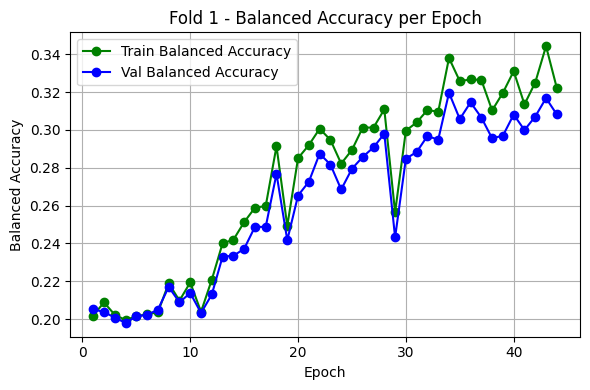


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.92      0.81      1785
           1       0.60      0.25      0.36       604
           2       0.33      0.22      0.27       258
           3       0.41      0.20      0.27        59
           4       0.00      0.00      0.00         9

    accuracy                           0.69      2715
   macro avg       0.42      0.32      0.34      2715
weighted avg       0.65      0.69      0.65      2715



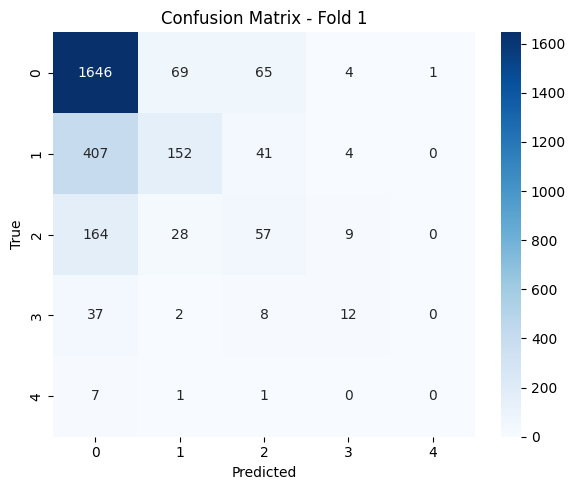

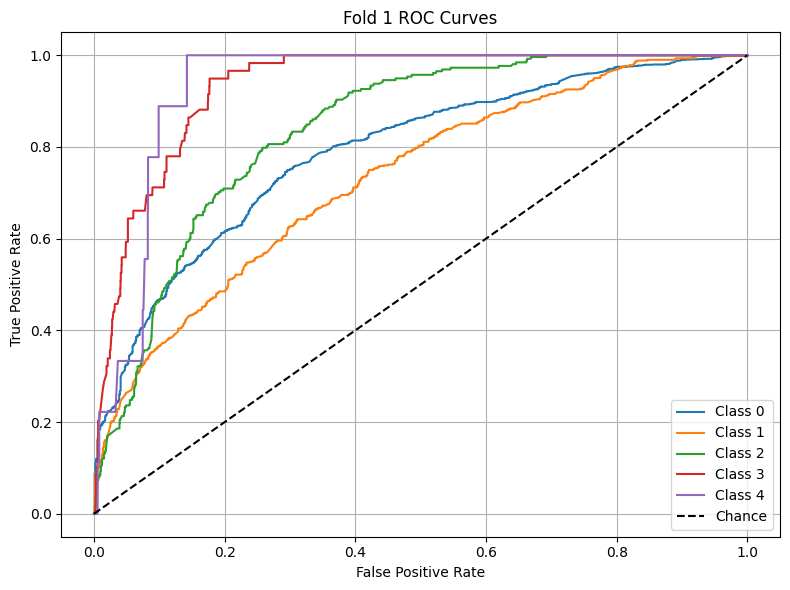


Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_balanced_accuracy = 0.27564


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


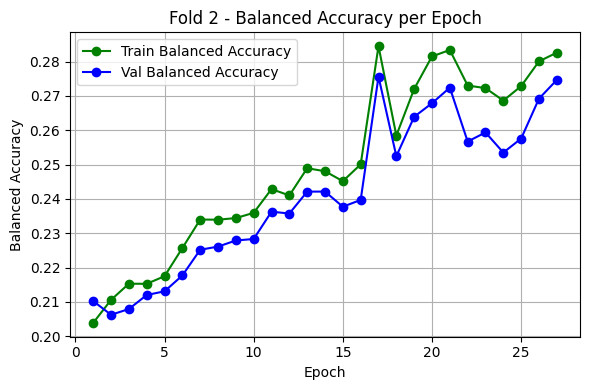

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.93      0.81      1786
           1       0.61      0.21      0.31       603
           2       0.34      0.24      0.28       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         8

    accuracy                           0.68      2714
   macro avg       0.33      0.28      0.28      2714
weighted avg       0.64      0.68      0.63      2714



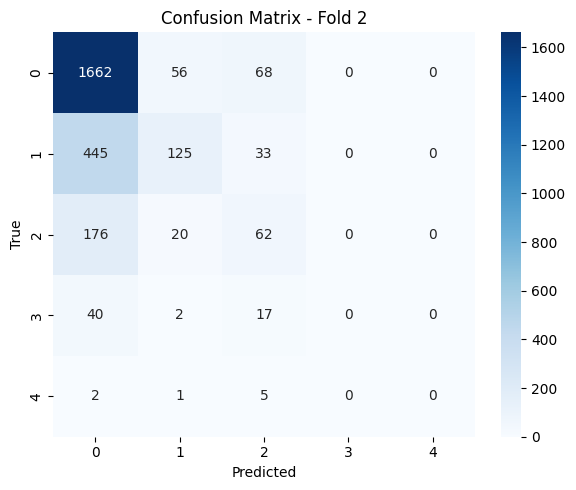

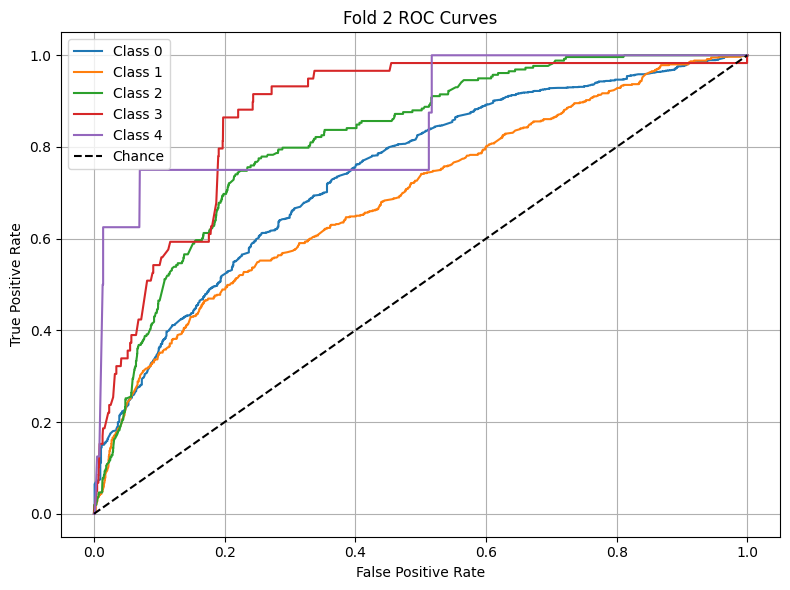


Early stopping occurred at epoch 64 with best_epoch = 54 and best_val_balanced_accuracy = 0.33448


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


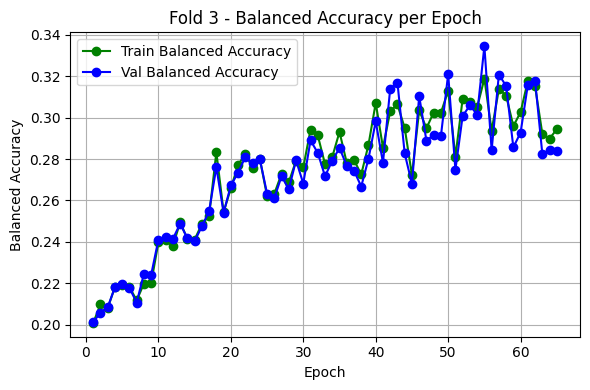

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.90      0.81      1786
           1       0.54      0.36      0.43       603
           2       0.50      0.26      0.34       258
           3       0.75      0.15      0.25        59
           4       0.00      0.00      0.00         8

    accuracy                           0.70      2714
   macro avg       0.51      0.33      0.37      2714
weighted avg       0.67      0.70      0.67      2714



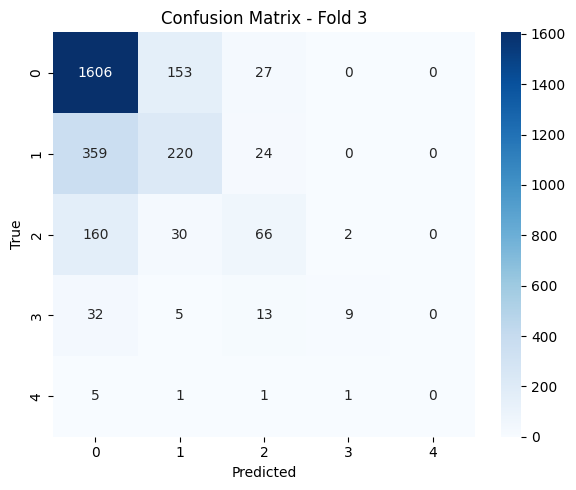

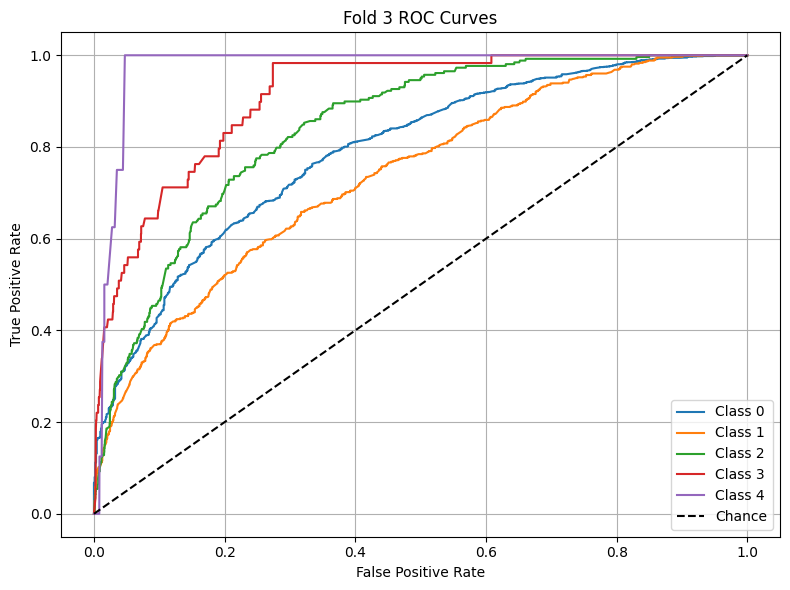


Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_balanced_accuracy = 0.29037


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


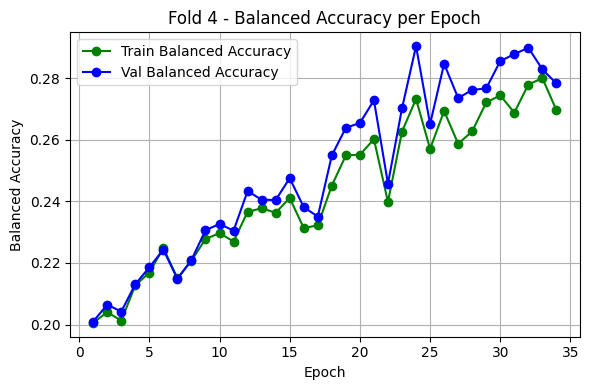

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.94      0.82      1785
           1       0.63      0.26      0.37       603
           2       0.50      0.24      0.33       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         9

    accuracy                           0.70      2714
   macro avg       0.37      0.29      0.30      2714
weighted avg       0.66      0.70      0.65      2714



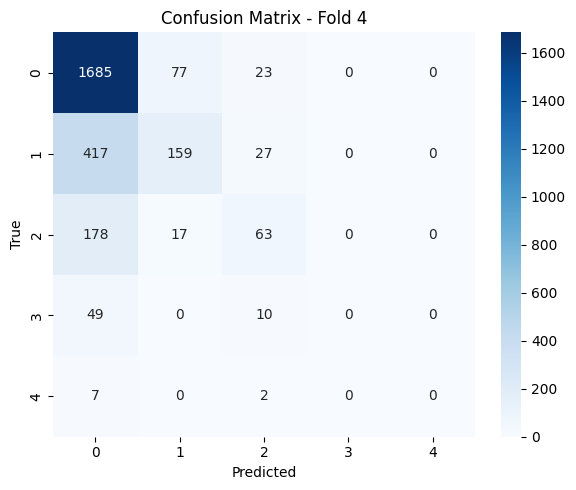

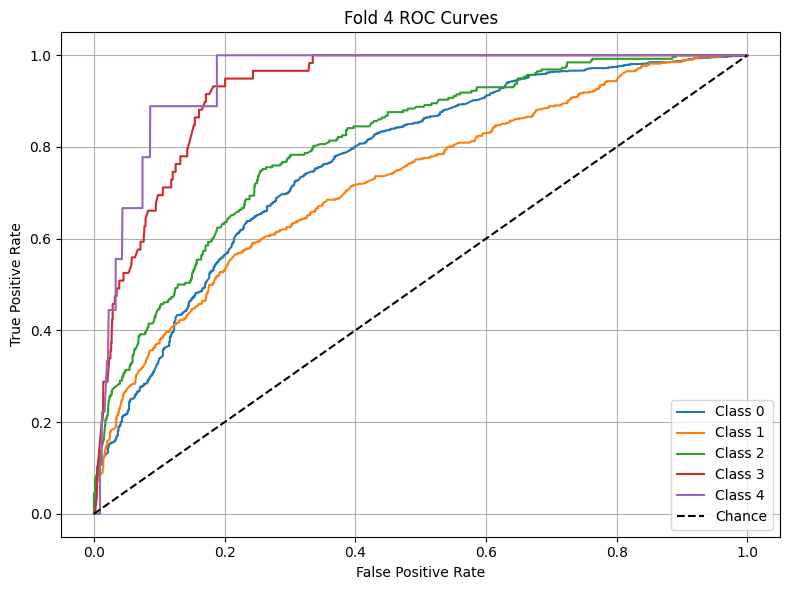


Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_balanced_accuracy = 0.32135


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


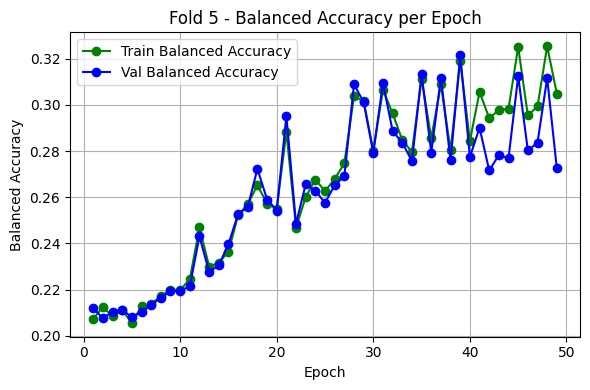

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.95      0.83      1785
           1       0.57      0.25      0.35       603
           2       0.43      0.22      0.29       258
           3       0.50      0.19      0.27        59
           4       0.00      0.00      0.00         9

    accuracy                           0.70      2714
   macro avg       0.45      0.32      0.35      2714
weighted avg       0.66      0.70      0.66      2714



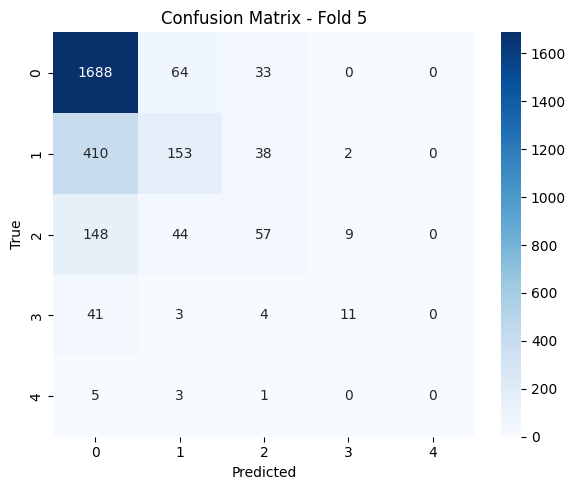

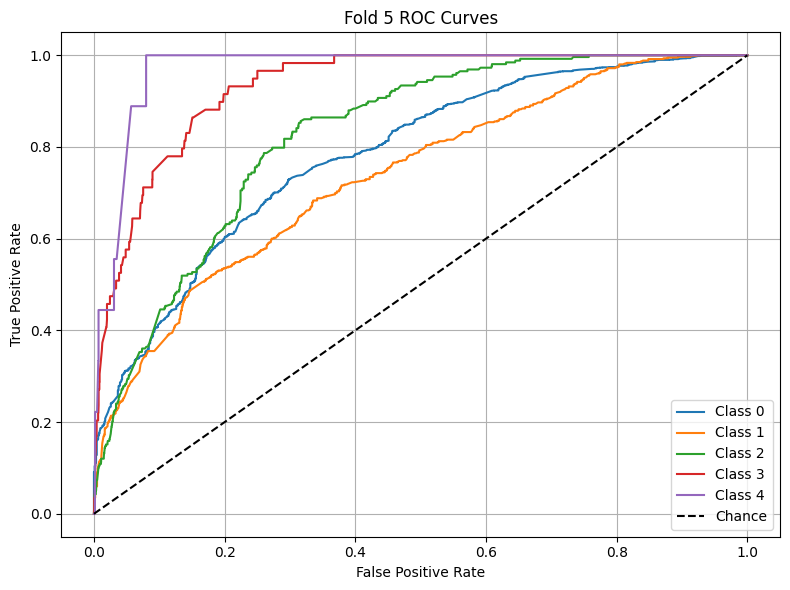


Average Accuracy: 0.6951
Average F1 Macro: 0.3283
Average AUC: 0.8351

Feature Importances:
assignment                         0.166132
school                             0.107087
exercise_count                     0.100700
exercise_perc_real_score_mean_1    0.092116
user_past_course_count             0.053412
remaining_time                     0.052146
exercise_id_count_1                0.051701
duration_days                      0.048148
video_count                        0.044177
exercise_num_problem_sum_1         0.038775
dtype: float64

=== Training Phase 2 ===

Early stopping occurred at epoch 54 with best_epoch = 44 and best_val_balanced_accuracy = 0.31165


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


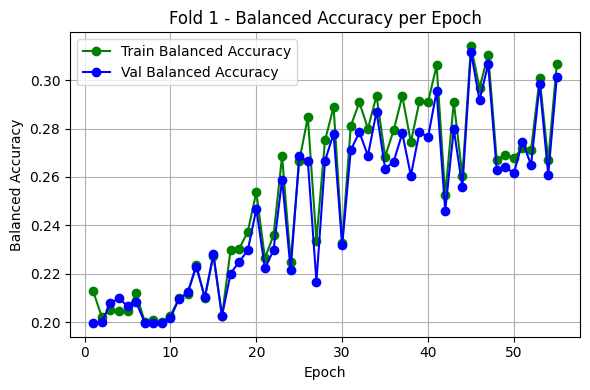

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.95      0.81      1489
           1       0.61      0.15      0.24       488
           2       0.45      0.24      0.31       220
           3       0.38      0.22      0.28        54
           4       0.00      0.00      0.00         9

    accuracy                           0.69      2260
   macro avg       0.43      0.31      0.33      2260
weighted avg       0.65      0.69      0.62      2260



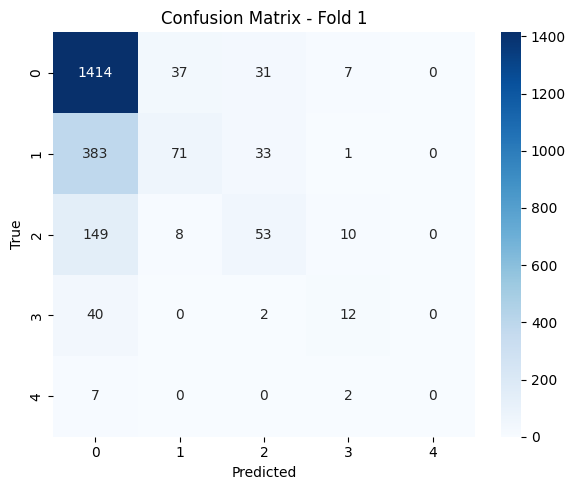

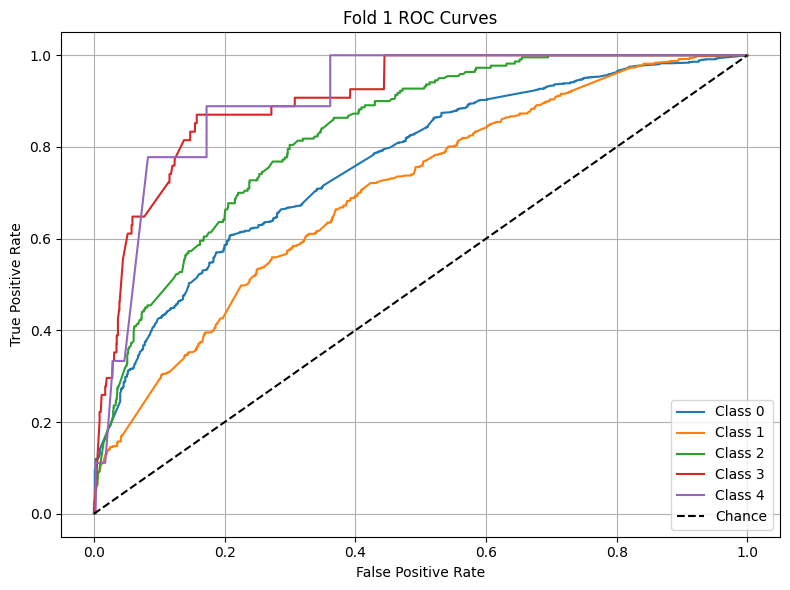


Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_balanced_accuracy = 0.22285


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


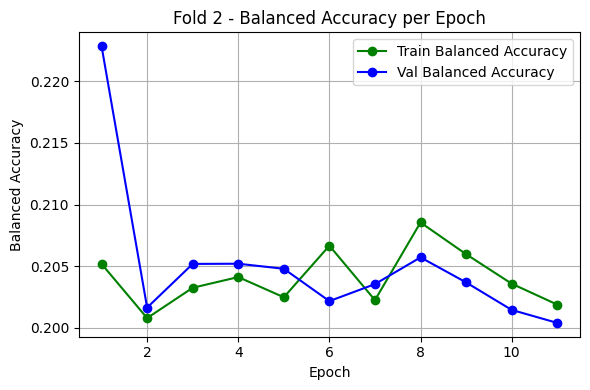


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.99      0.79      1489
           1       0.00      0.00      0.00       489
           2       0.00      0.00      0.00       219
           3       0.00      0.00      0.00        55
           4       0.07      0.12      0.09         8

    accuracy                           0.65      2260
   macro avg       0.15      0.22      0.18      2260
weighted avg       0.43      0.65      0.52      2260



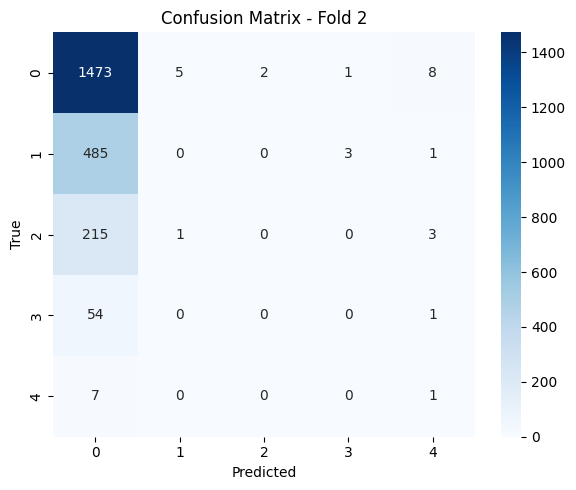

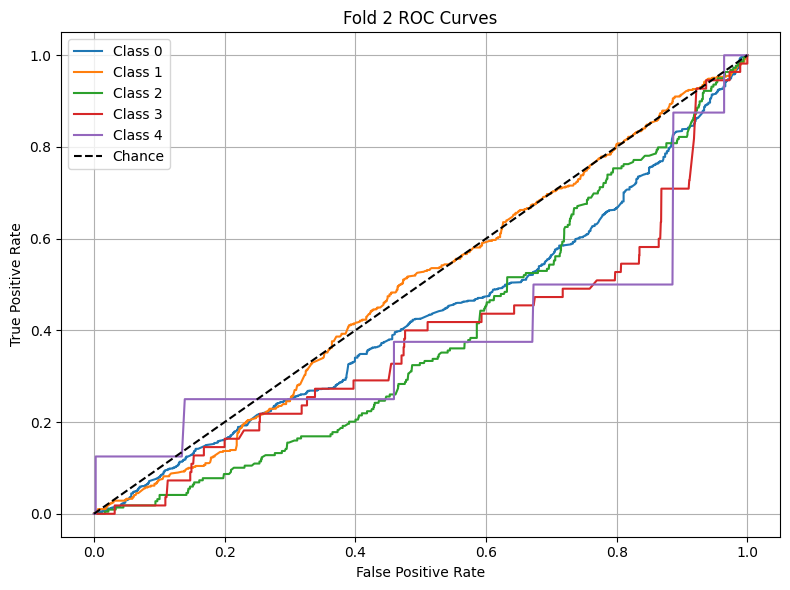


Early stopping occurred at epoch 85 with best_epoch = 75 and best_val_balanced_accuracy = 0.33964


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


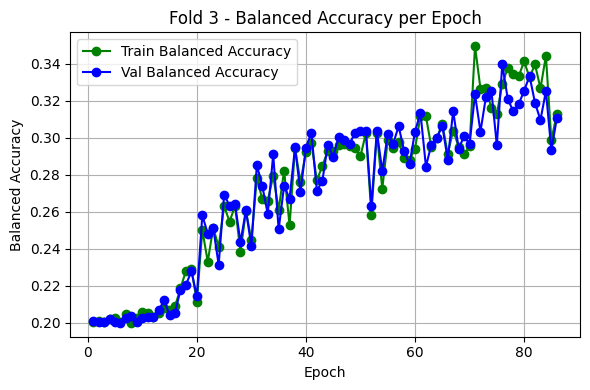

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.95      0.83      1489
           1       0.51      0.17      0.26       489
           2       0.48      0.33      0.39       219
           3       0.48      0.24      0.32        54
           4       0.00      0.00      0.00         8

    accuracy                           0.70      2259
   macro avg       0.44      0.34      0.36      2259
weighted avg       0.66      0.70      0.65      2259



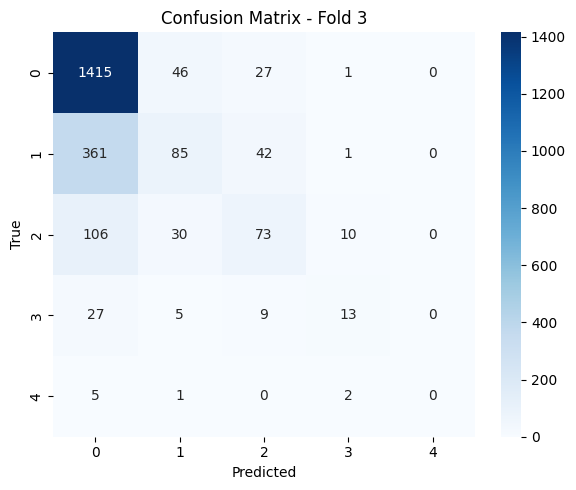

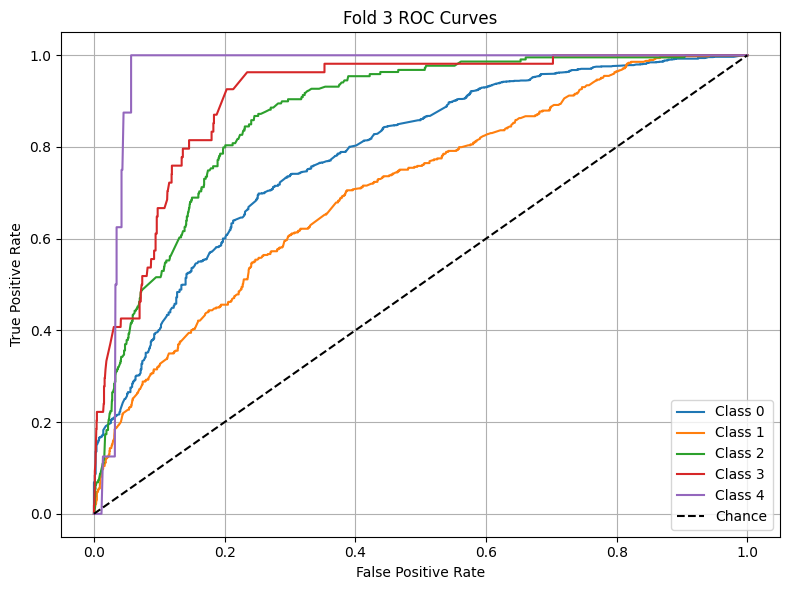


Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_balanced_accuracy = 0.22353


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


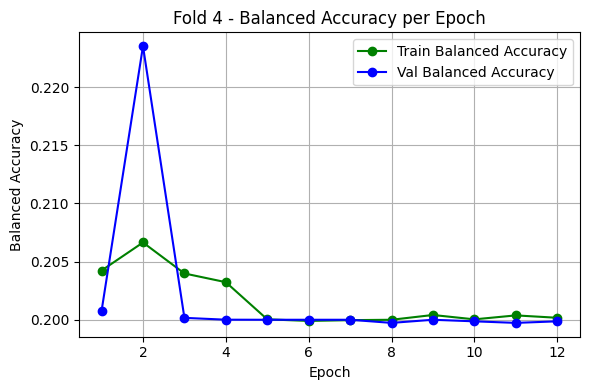

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.99      0.79      1489
           1       0.09      0.00      0.00       489
           2       0.00      0.00      0.00       219
           3       0.00      0.00      0.00        54
           4       0.08      0.12      0.10         8

    accuracy                           0.65      2259
   macro avg       0.17      0.22      0.18      2259
weighted avg       0.46      0.65      0.52      2259



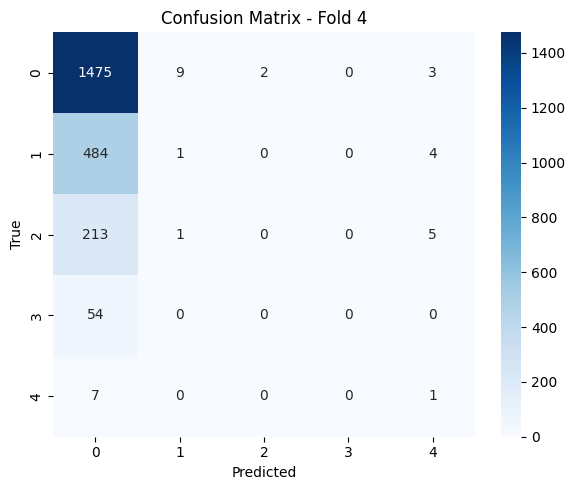

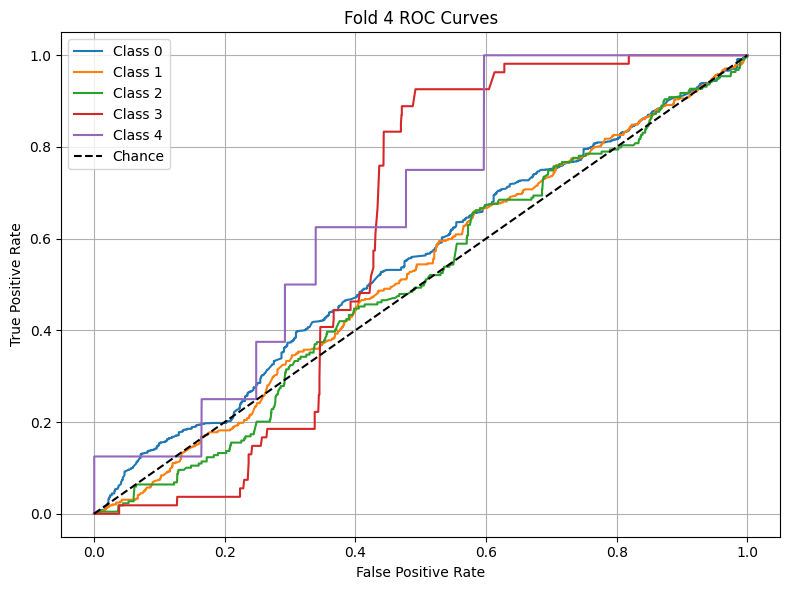


Early stopping occurred at epoch 75 with best_epoch = 65 and best_val_balanced_accuracy = 0.31759


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


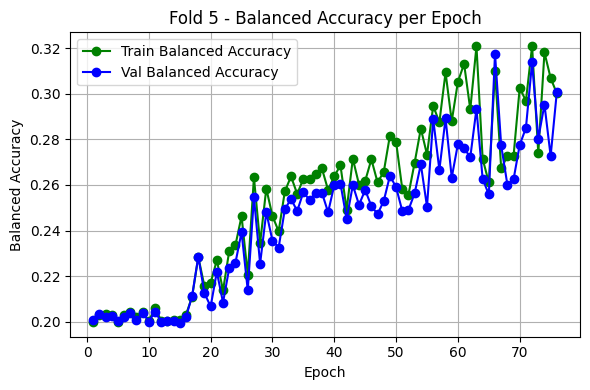

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.82      1490
           1       0.51      0.21      0.30       488
           2       0.39      0.32      0.35       219
           3       0.00      0.00      0.00        54
           4       1.00      0.12      0.22         8

    accuracy                           0.69      2259
   macro avg       0.53      0.32      0.34      2259
weighted avg       0.64      0.69      0.64      2259



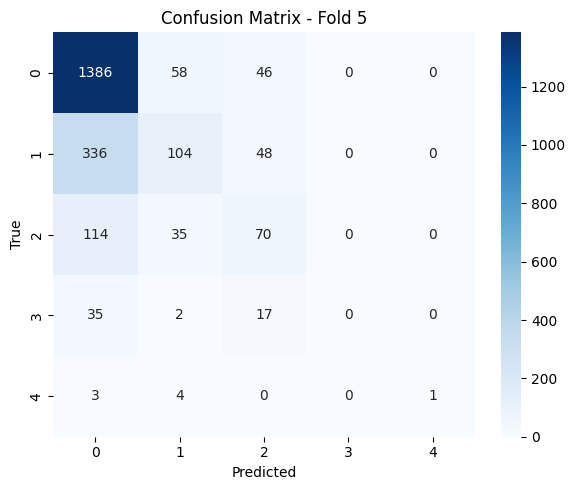

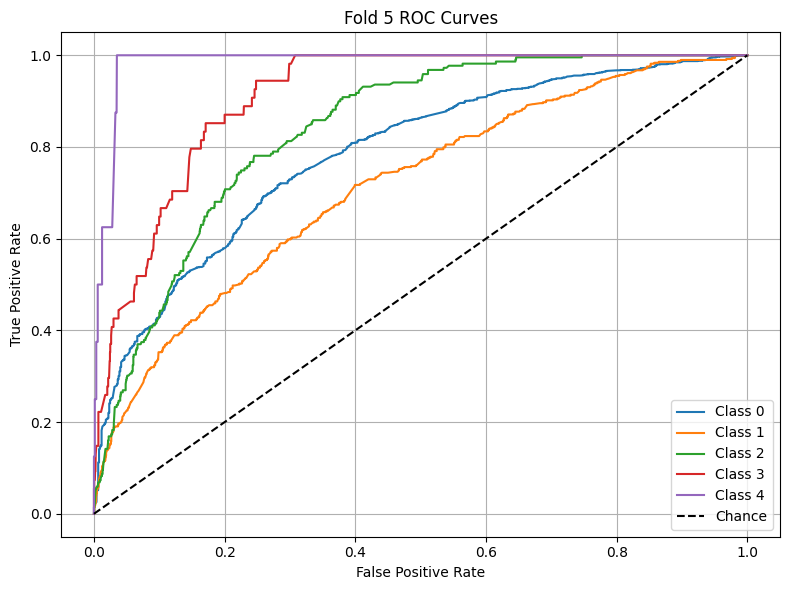


Average Accuracy: 0.6770
Average F1 Macro: 0.2767
Average AUC: 0.6994

Feature Importances:
assignment                     0.266308
encoded_field_sum              0.081991
duration_days                  0.078288
video_count                    0.062965
exercise_count                 0.057327
exercise_correct_sum_1         0.053779
chapter_count                  0.053703
video_watched_percentage_2     0.051186
entropy_time_comment_phase2    0.045525
video                          0.041202
dtype: float64

=== Training Phase 3 ===

Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_balanced_accuracy = 0.29177


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


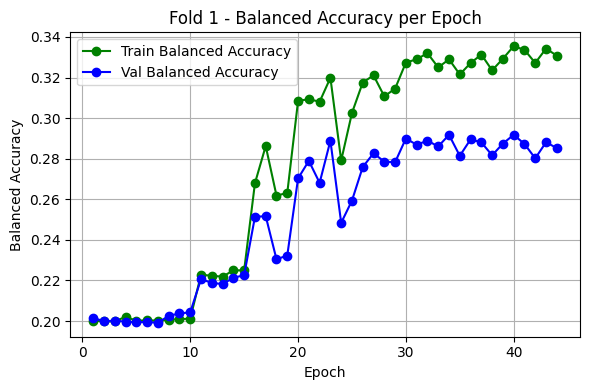

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.94      0.82      1361
           1       0.52      0.18      0.27       459
           2       0.35      0.20      0.26       198
           3       0.17      0.14      0.15        49
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2074
   macro avg       0.35      0.29      0.30      2074
weighted avg       0.63      0.68      0.62      2074



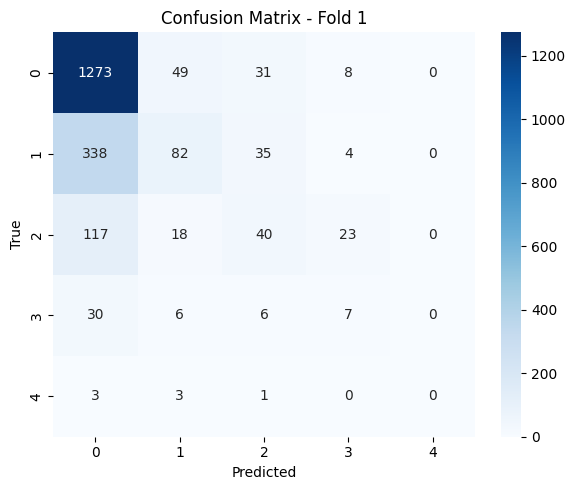

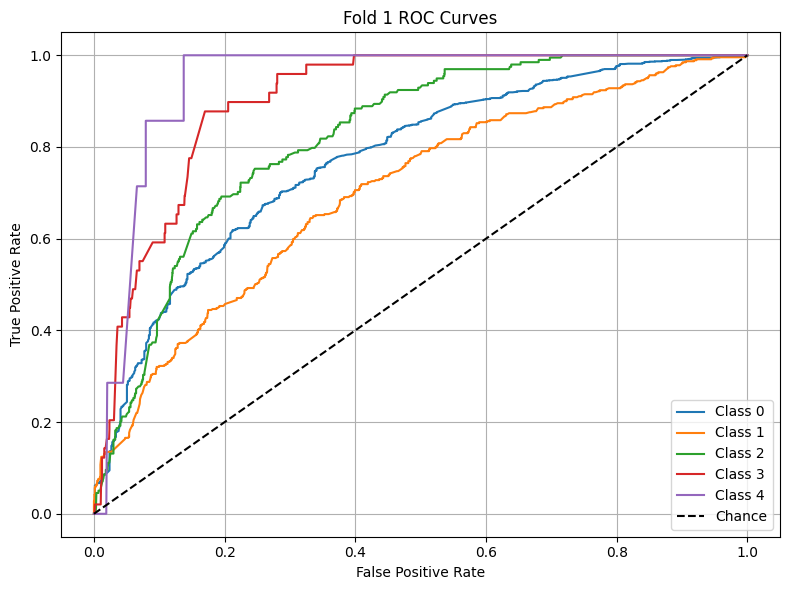


Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_balanced_accuracy = 0.22419


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


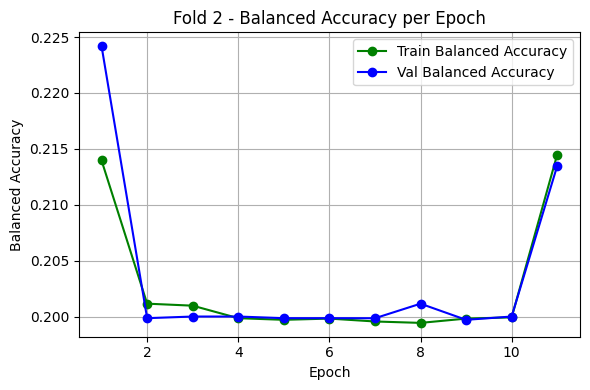

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.85      0.76      1360
           1       0.29      0.23      0.26       459
           2       0.00      0.00      0.00       198
           3       0.06      0.04      0.05        50
           4       0.00      0.00      0.00         7

    accuracy                           0.61      2074
   macro avg       0.21      0.22      0.21      2074
weighted avg       0.52      0.61      0.56      2074



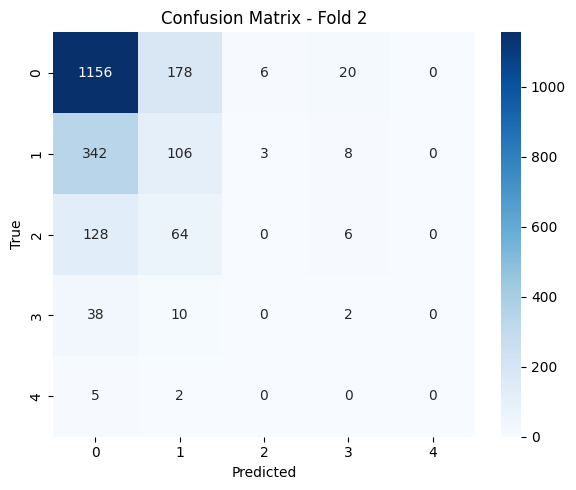

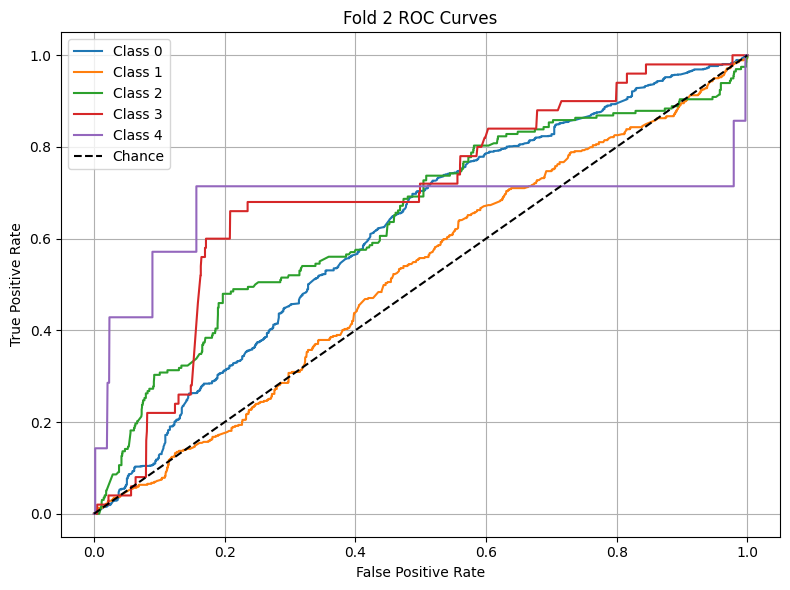


Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_balanced_accuracy = 0.21025


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


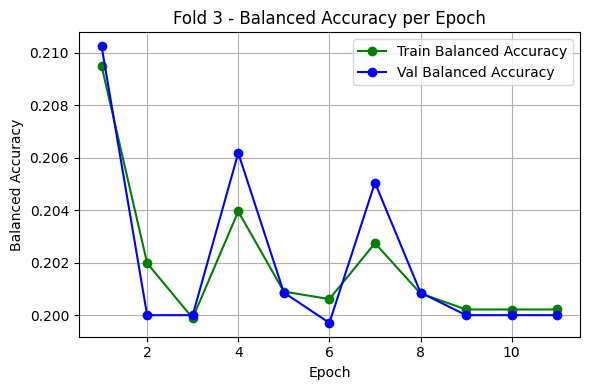

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.92      0.78      1360
           1       0.27      0.13      0.17       459
           2       0.33      0.01      0.01       198
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00         7

    accuracy                           0.63      2074
   macro avg       0.26      0.21      0.19      2074
weighted avg       0.54      0.63      0.55      2074



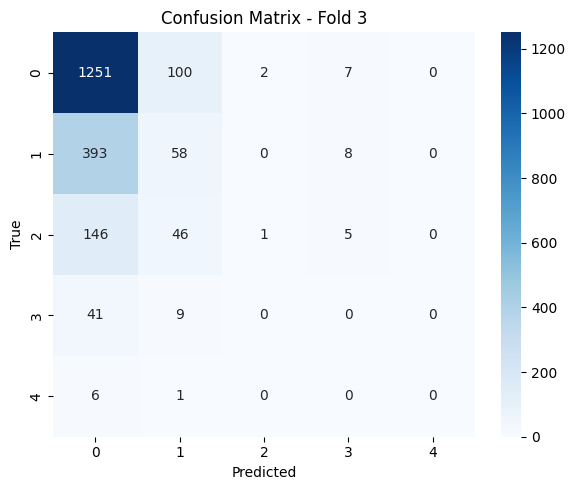

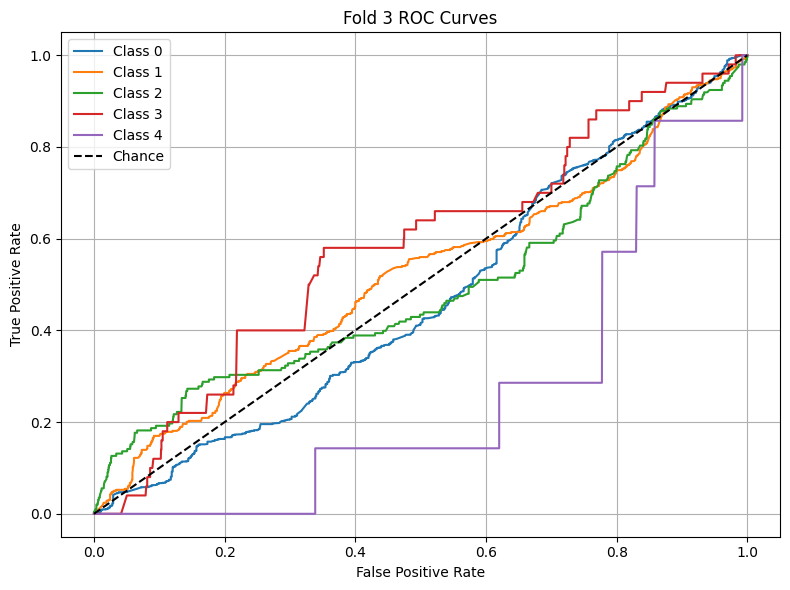


Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_balanced_accuracy = 0.20486


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


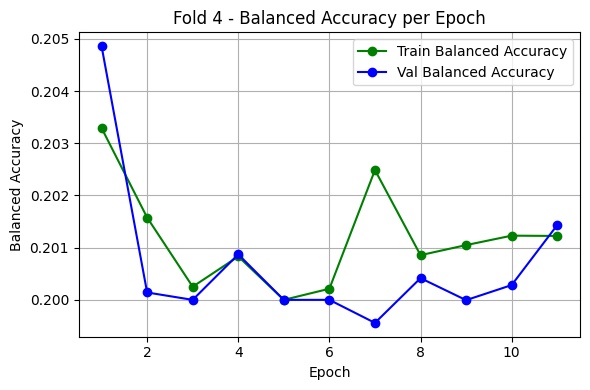

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.97      0.79      1360
           1       0.30      0.05      0.08       459
           2       0.33      0.01      0.01       198
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00         7

    accuracy                           0.65      2074
   macro avg       0.26      0.20      0.18      2074
weighted avg       0.54      0.65      0.54      2074



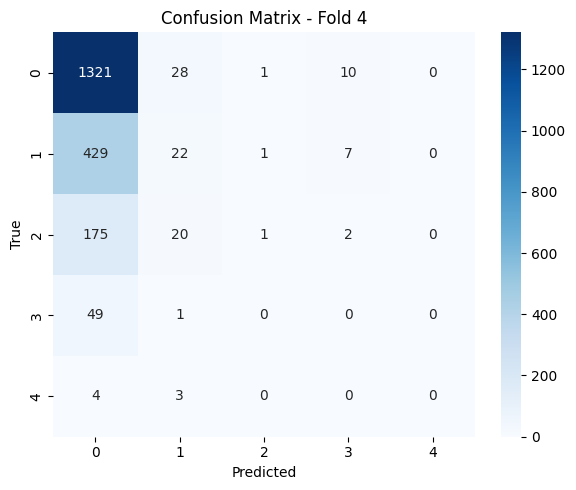

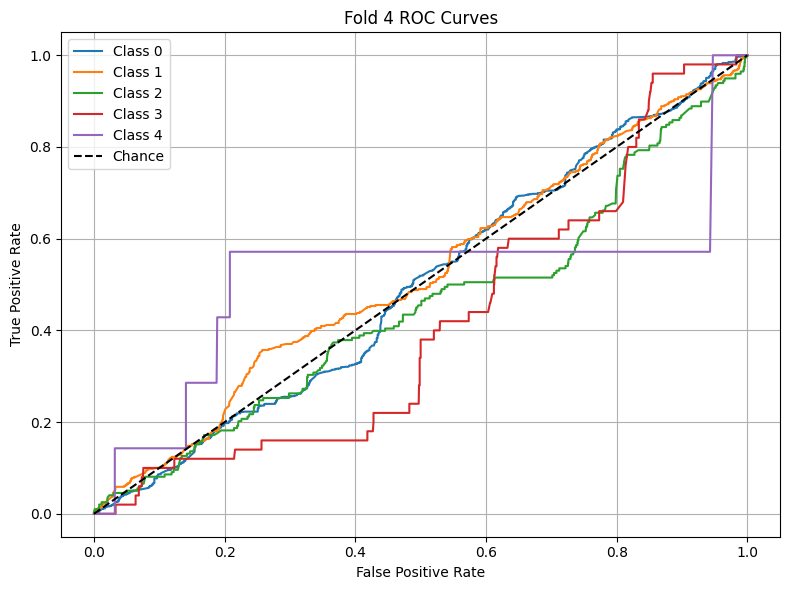


Early stopping occurred at epoch 53 with best_epoch = 43 and best_val_balanced_accuracy = 0.31304


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


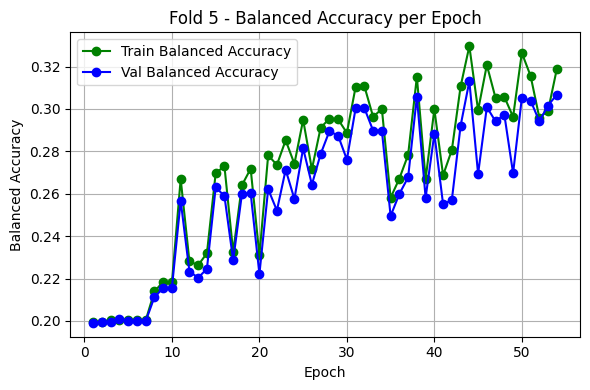

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.95      0.81      1360
           1       0.59      0.13      0.21       460
           2       0.40      0.26      0.32       197
           3       0.34      0.22      0.27        49
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2073
   macro avg       0.41      0.31      0.32      2073
weighted avg       0.64      0.68      0.62      2073



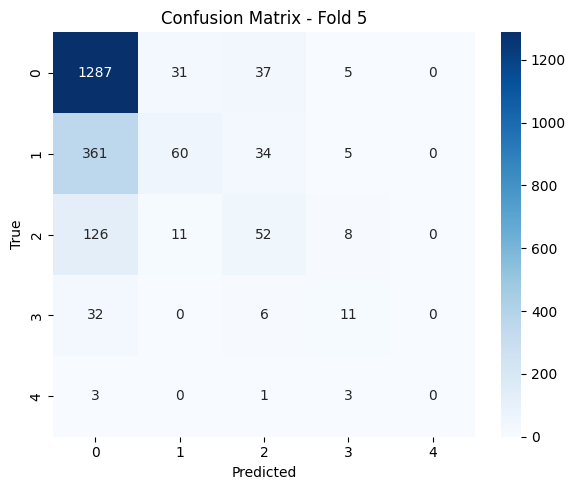

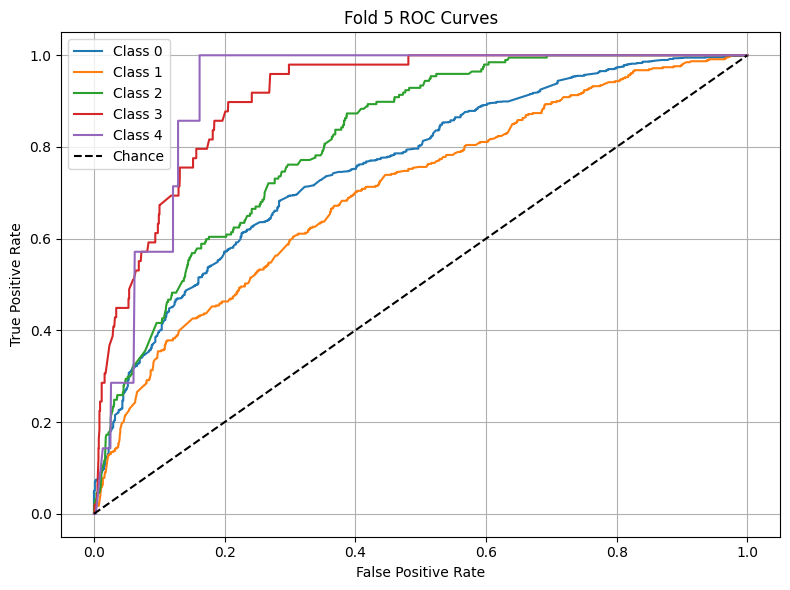


Average Accuracy: 0.6491
Average F1 Macro: 0.2410
Average AUC: 0.6441

Feature Importances:
video                                  0.414877
video_count                            0.073994
video_watched_percentage_3             0.063560
exercise_count                         0.062391
assignment                             0.057352
end_year                               0.038942
video_time_between_views_std_3         0.034947
chapter_count                          0.032701
exercise_perc_real_completed_mean_1    0.025893
video_time_between_views_std_1         0.021700
dtype: float64

=== Training Phase 4 ===

Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_balanced_accuracy = 0.25718


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


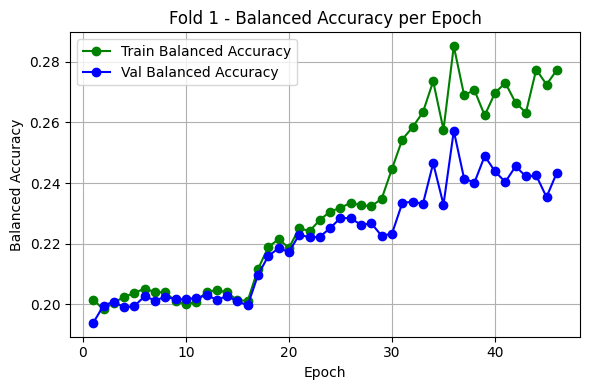

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.90      0.78      1000
           1       0.52      0.35      0.42       355
           2       0.38      0.04      0.07       139
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00         6

    accuracy                           0.67      1539
   macro avg       0.32      0.26      0.25      1539
weighted avg       0.61      0.67      0.61      1539



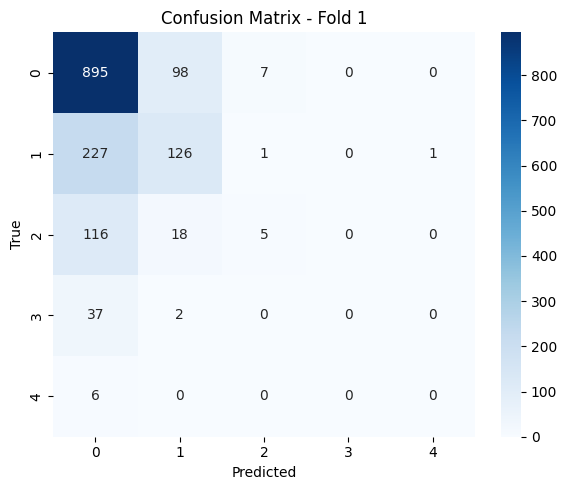

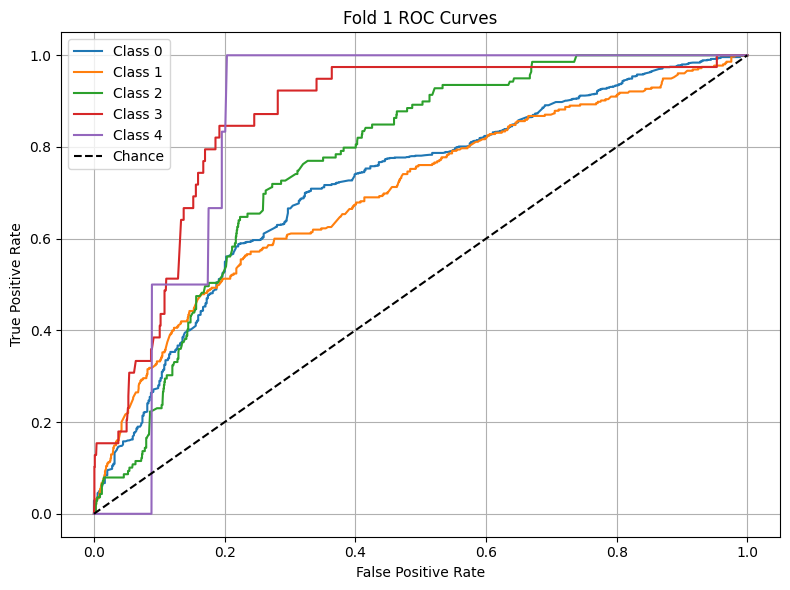


Early stopping occurred at epoch 75 with best_epoch = 65 and best_val_balanced_accuracy = 0.35423


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


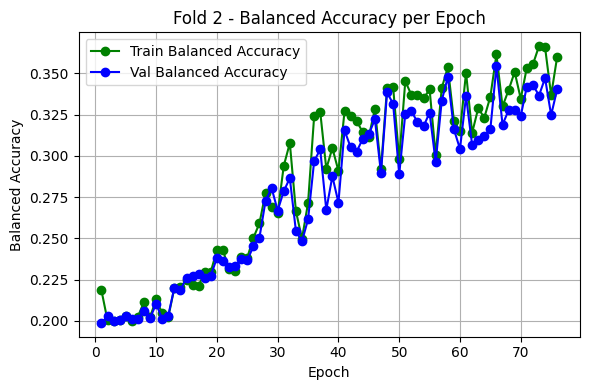


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.82      1000
           1       0.61      0.30      0.40       355
           2       0.56      0.32      0.40       139
           3       0.39      0.23      0.29        40
           4       0.00      0.00      0.00         5

    accuracy                           0.71      1539
   macro avg       0.46      0.35      0.38      1539
weighted avg       0.68      0.71      0.67      1539



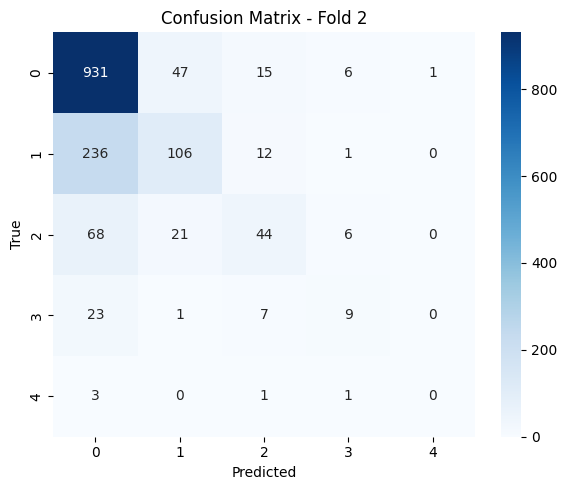

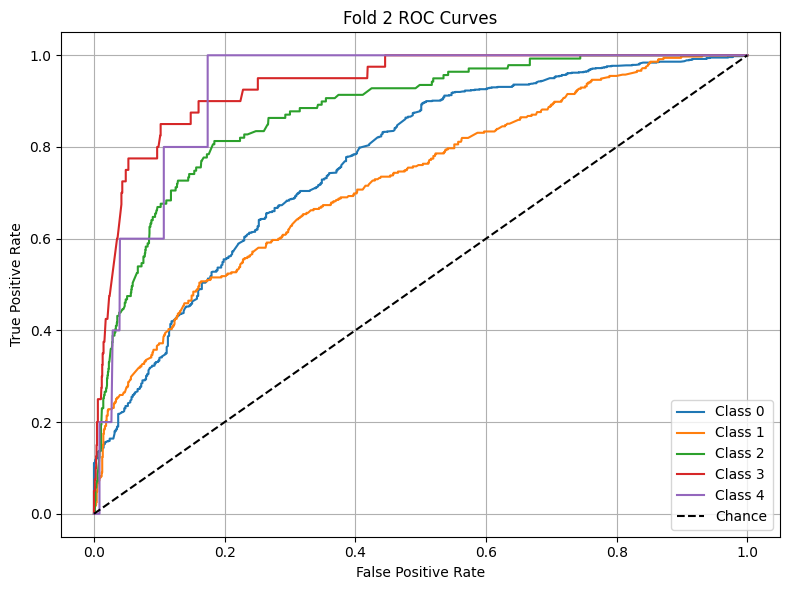


Early stopping occurred at epoch 60 with best_epoch = 50 and best_val_balanced_accuracy = 0.33528


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


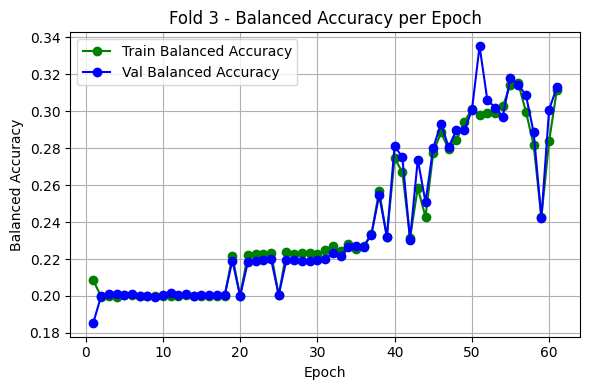


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.94      0.81       999
           1       0.56      0.26      0.36       355
           2       0.00      0.00      0.00       139
           3       0.46      0.30      0.36        40
           4       1.00      0.17      0.29         6

    accuracy                           0.68      1539
   macro avg       0.54      0.34      0.36      1539
weighted avg       0.60      0.68      0.62      1539



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


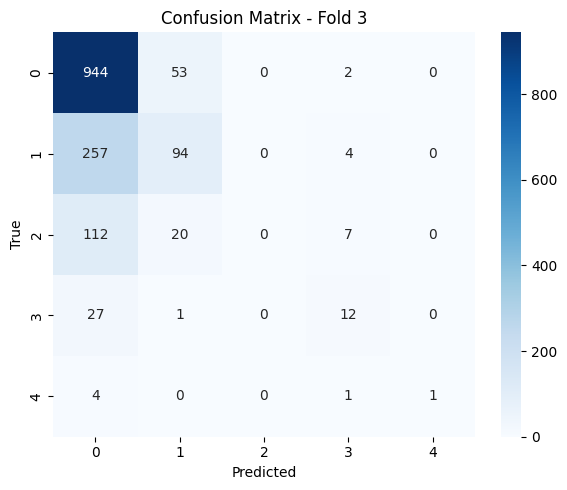

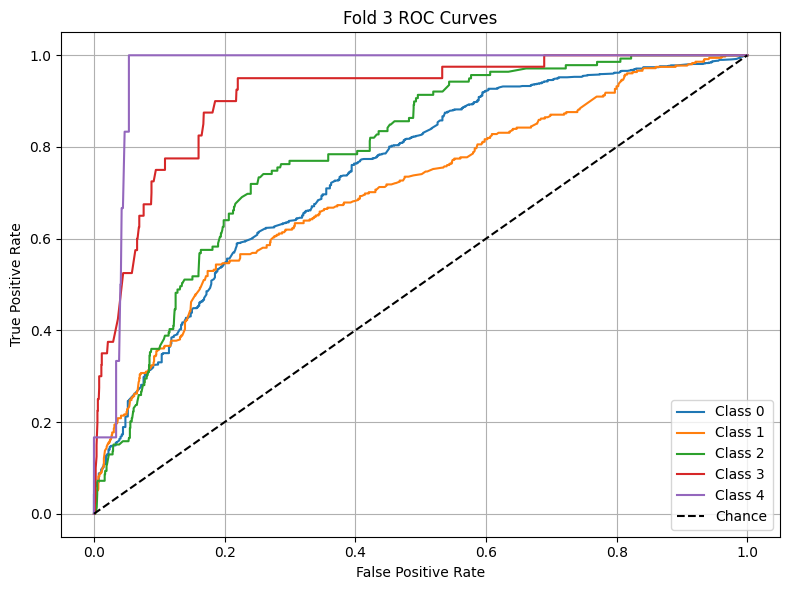


Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_balanced_accuracy = 0.2055


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


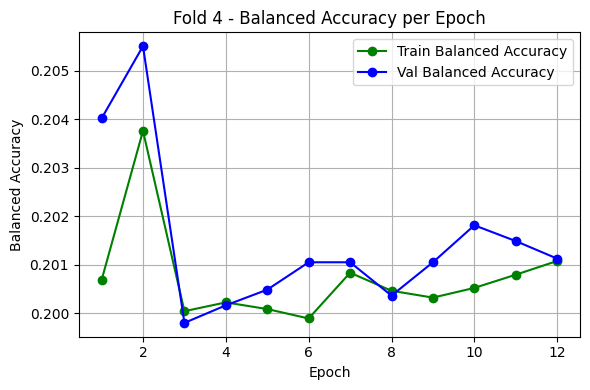


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.99      0.79       999
           1       0.59      0.04      0.07       356
           2       0.00      0.00      0.00       138
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00         6

    accuracy                           0.65      1538
   macro avg       0.25      0.21      0.17      1538
weighted avg       0.56      0.65      0.53      1538



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


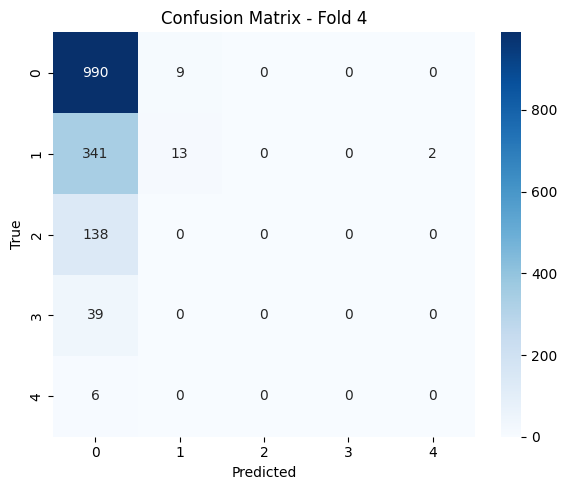

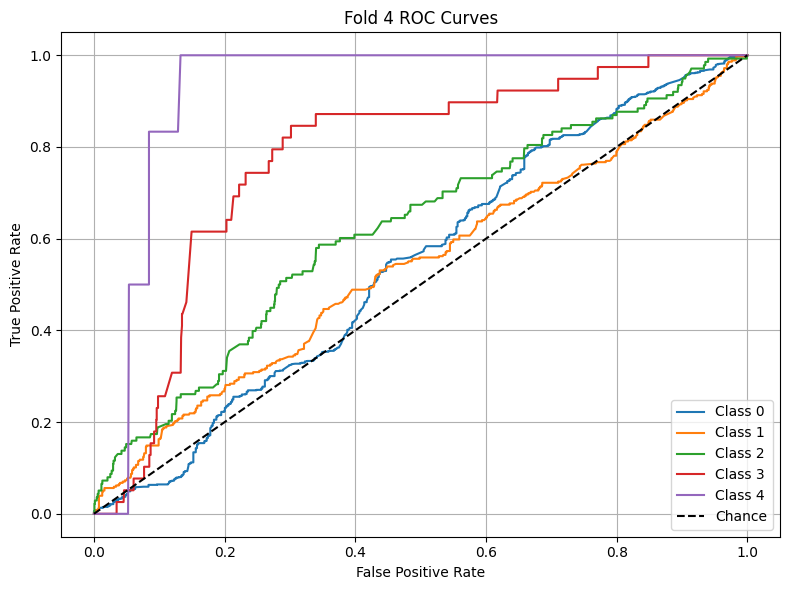


Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_balanced_accuracy = 0.20986


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


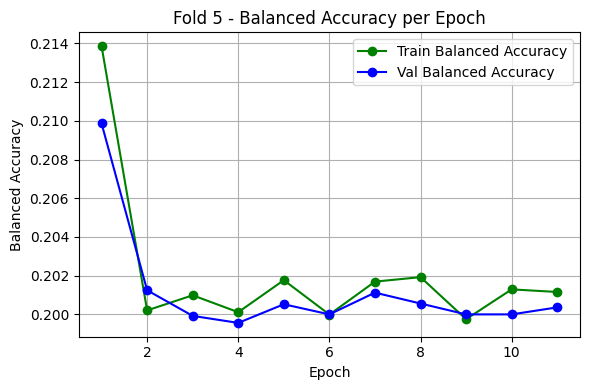


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.86      0.74       999
           1       0.28      0.18      0.22       356
           2       0.33      0.01      0.03       138
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00         6

    accuracy                           0.60      1538
   macro avg       0.25      0.21      0.20      1538
weighted avg       0.52      0.60      0.54      1538



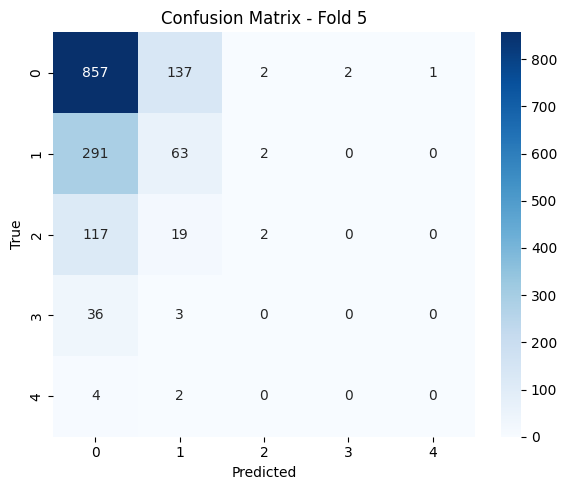

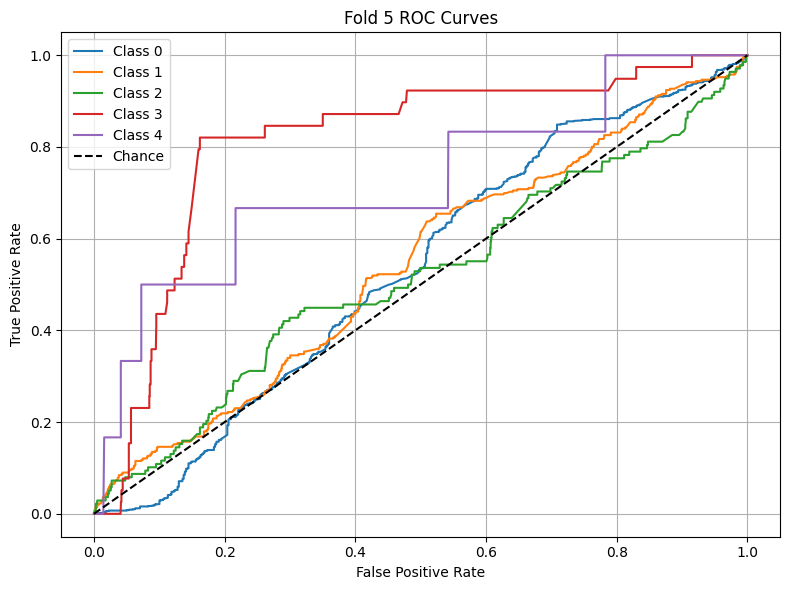


Average Accuracy: 0.6619
Average F1 Macro: 0.2738
Average AUC: 0.7516

Feature Importances:
remaining_time                     0.169969
chapter_count                      0.118388
school                             0.113365
user_month                         0.066034
exercise_perc_real_score_mean_4    0.064843
total_words_phase1                 0.061287
exercise_count                     0.054550
assignment                         0.038506
exercise_num_problem_sum_4         0.029695
video_watched_percentage_4         0.026194
dtype: float64


In [6]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [7]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       568
           1       0.23      0.11      0.15        63
           2       0.14      0.12      0.13        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.77       698
   macro avg       0.24      0.23      0.23       698
weighted avg       0.71      0.77      0.73       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


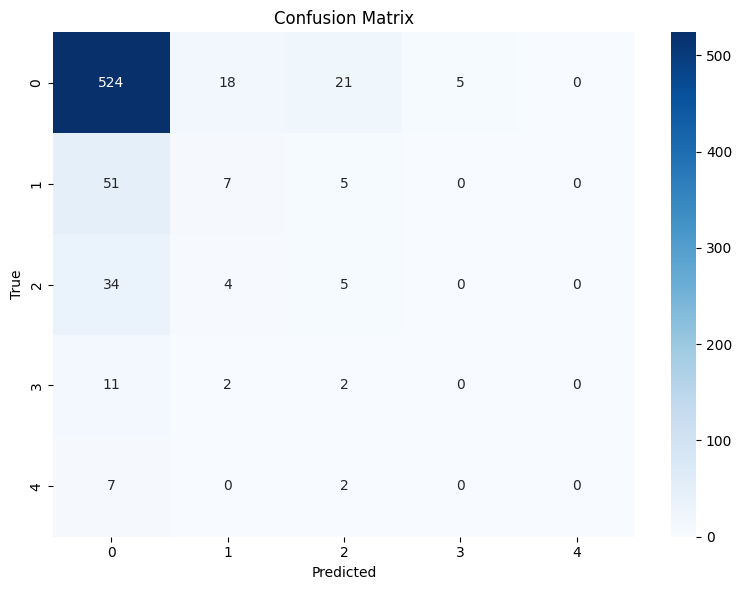


Test AUC (macro-average, OVR): 0.6539


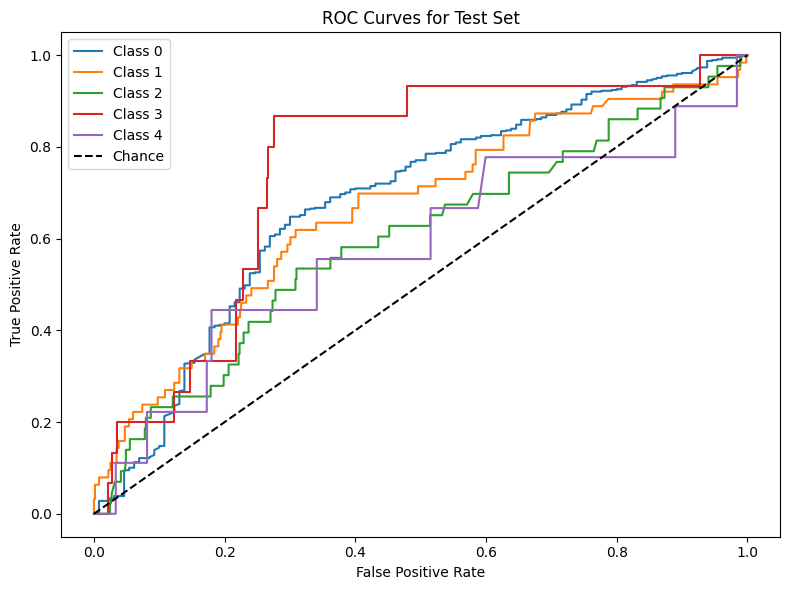


Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       544
           1       0.13      0.19      0.15        59
           2       0.26      0.19      0.22        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.72       668
   macro avg       0.24      0.24      0.24       668
weighted avg       0.71      0.72      0.71       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


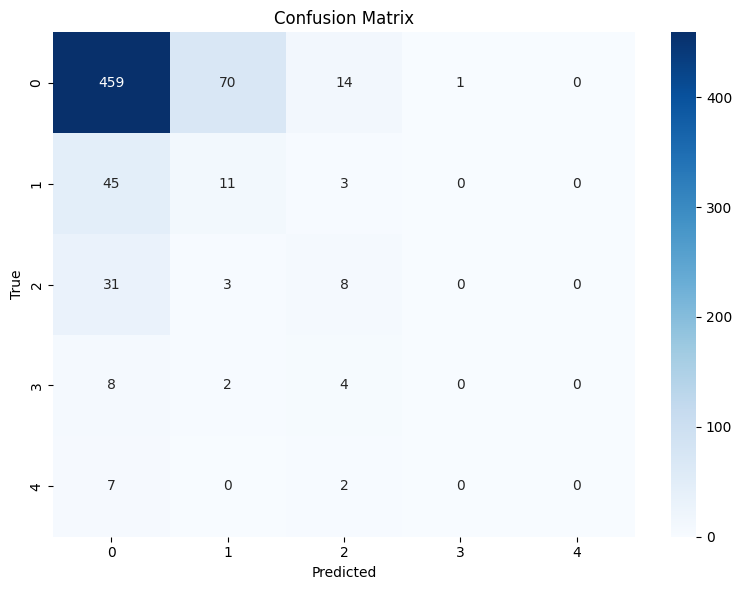


Test AUC (macro-average, OVR): 0.6980


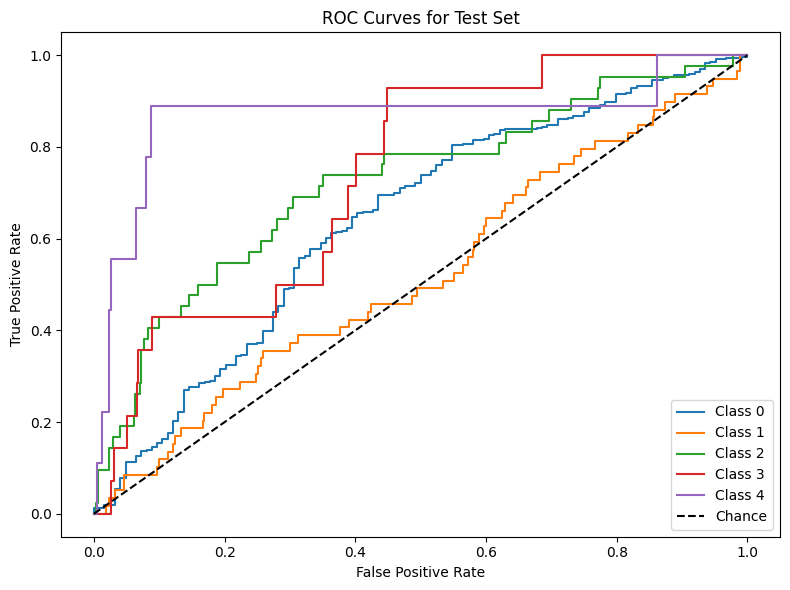


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       455
           1       0.26      0.23      0.24        52
           2       0.07      0.10      0.08        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.74       554
   macro avg       0.24      0.24      0.24       554
weighted avg       0.72      0.74      0.73       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


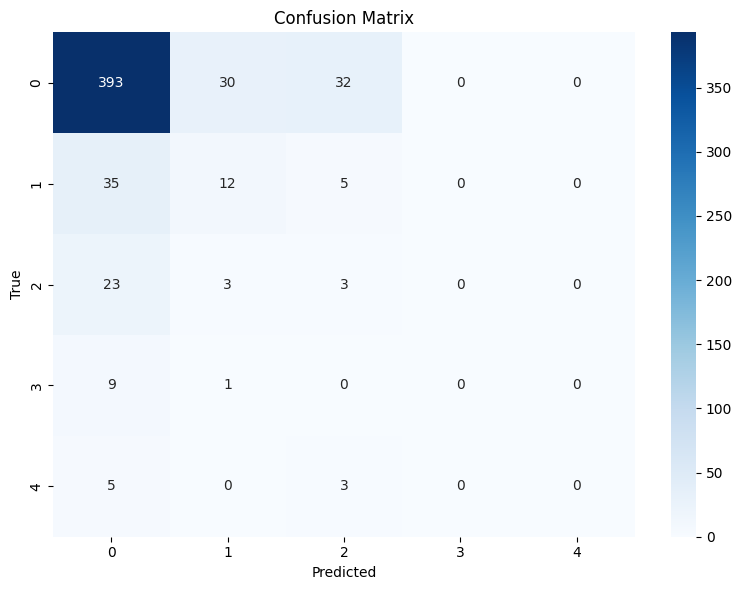


Test AUC (macro-average, OVR): 0.6645


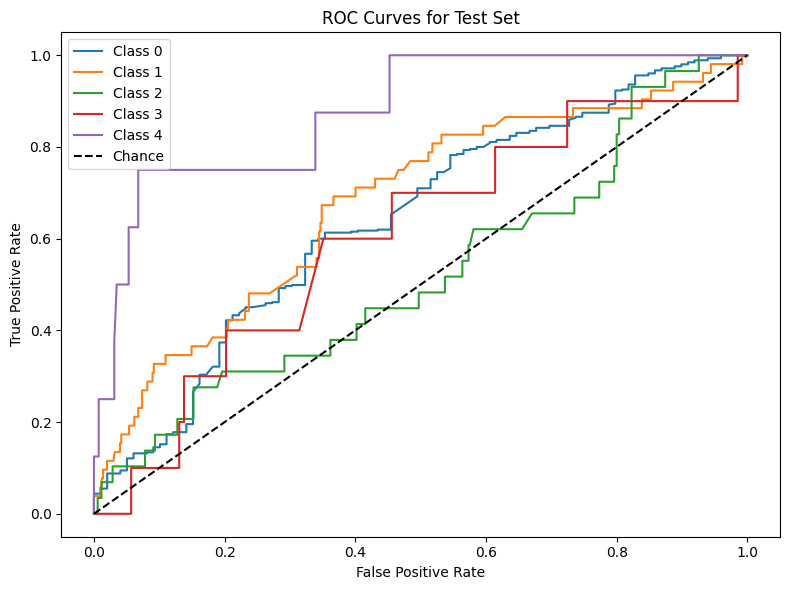


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       395
           1       0.05      0.05      0.05        40
           2       0.09      0.29      0.14        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.66       477
   macro avg       0.20      0.22      0.20       477
weighted avg       0.70      0.66      0.68       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


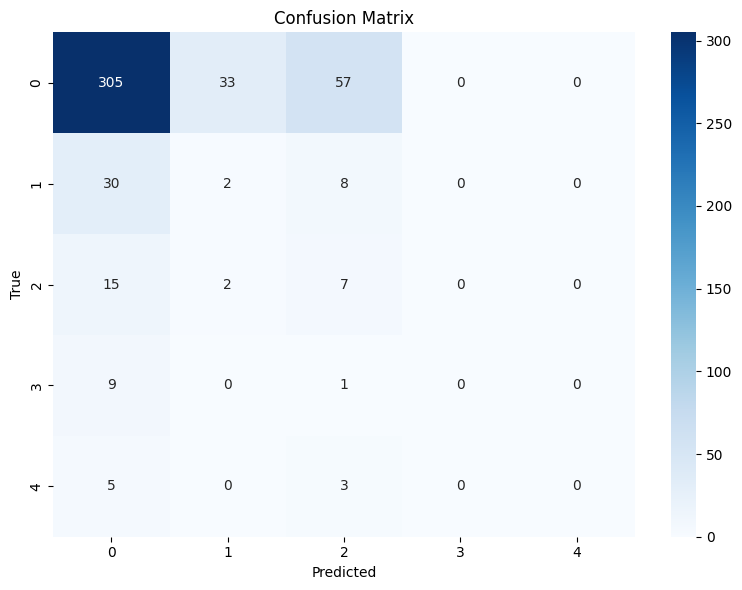


Test AUC (macro-average, OVR): 0.5914


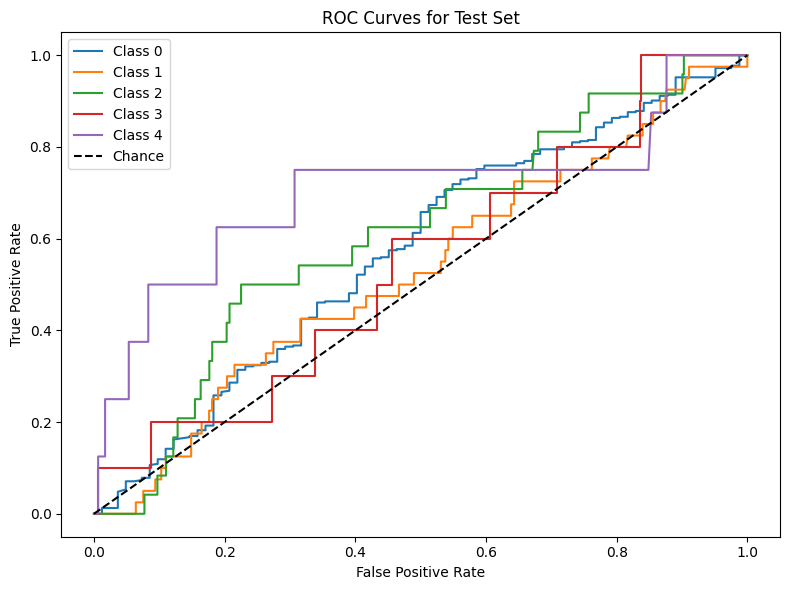

In [8]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample

In [9]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import LabelEncoder, label_binarize

def train_not_balance_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_fold = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled_np = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled_np = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled_np, columns=X_val.columns)

        # Encode target labels
        label_encoder = LabelEncoder()
        y_train_enc = label_encoder.fit_transform(y_train)
        y_val_enc = label_encoder.transform(y_val)
        class_names = label_encoder.classes_

        # Convert to NumPy arrays
        X_train_np = X_train_scaled.values
        X_val_np = X_val_scaled.values

        # Define and train TabNet model
        model = TabNetClassifier(
            seed=random_state,
            verbose=0
        )

        model.fit(
            X_train=X_train_np, y_train=y_train_enc,
            eval_set=[(X_train_np, y_train_enc), (X_val_np, y_val_enc)],
            eval_name=['train', 'val'],
            eval_metric=['accuracy'],
            max_epochs=100,
            patience=10,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0
        )

        # Plot training history
        history = model.history.history
        val_acc = history.get('val_accuracy', None)
        train_acc = history.get('train_accuracy', None)
        epochs = list(range(1, len(val_acc) + 1)) if val_acc else []
        
        if val_acc and train_acc:
            plt.figure(figsize=(6, 4))
            plt.plot(epochs, train_acc, label='Train Accuracy', marker='o', color='green')
            plt.plot(epochs, val_acc, label='Val Accuracy', marker='o', color='blue')
            plt.title(f'Fold {fold} - Balanced Accuracy per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Balanced Accuracy')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

        # Evaluate
        y_pred_enc = model.predict(X_val_np)
        y_pred = label_encoder.inverse_transform(y_pred_enc)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # AUC
        y_proba = model.predict_proba(X_val_np)
        y_val_bin = label_binarize(y_val_enc, classes=np.arange(len(class_names)))
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold
            best_label_encoder = label_encoder

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, class_label in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {class_label}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.title(f'Fold {fold} ROC Curves')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature Importances
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feature_importances.head(10))

    return best_model, best_scaler, best_fold, all_metrics



=== Training Phase 1 ===

Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_accuracy = 0.63204


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


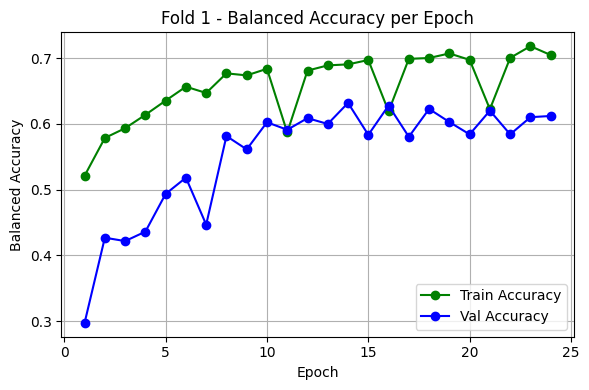


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.72      0.78      1785
           1       0.48      0.47      0.47       604
           2       0.33      0.43      0.37       258
           3       0.15      0.41      0.22        59
           4       0.07      0.67      0.12         9

    accuracy                           0.63      2715
   macro avg       0.37      0.54      0.39      2715
weighted avg       0.69      0.63      0.66      2715



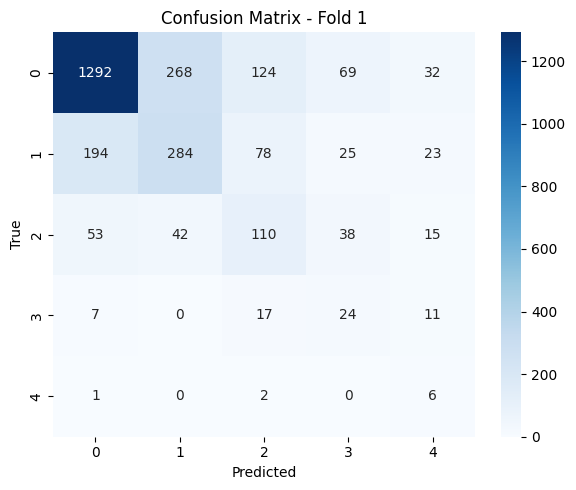

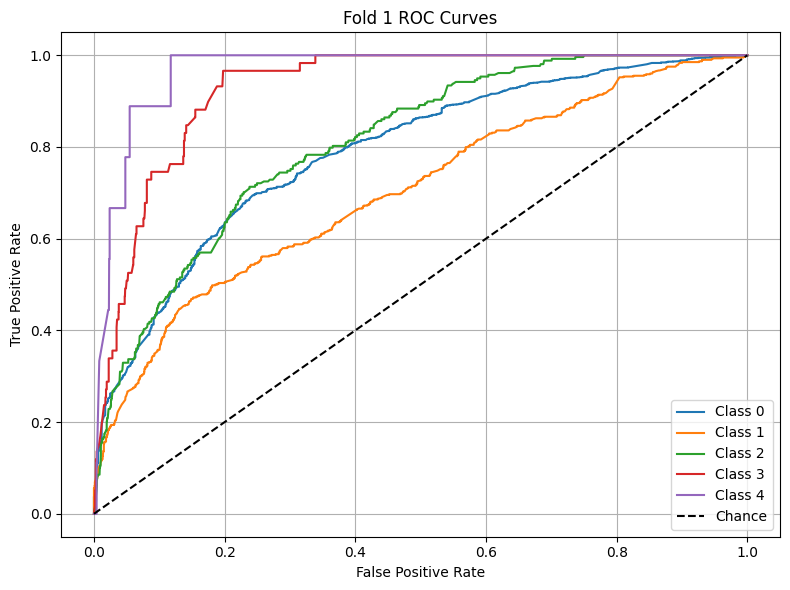


Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_accuracy = 0.62012


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


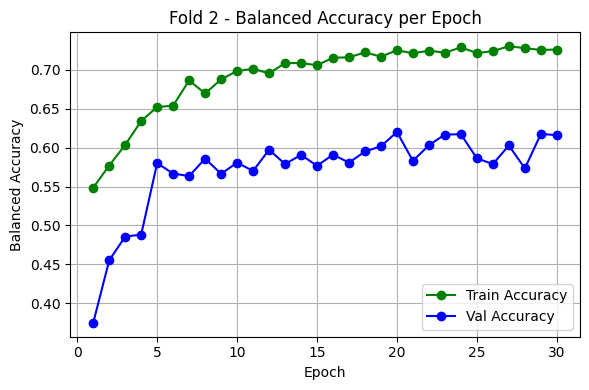


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.70      0.76      1786
           1       0.49      0.44      0.46       603
           2       0.31      0.53      0.40       258
           3       0.20      0.53      0.29        59
           4       0.03      0.25      0.06         8

    accuracy                           0.62      2714
   macro avg       0.37      0.49      0.39      2714
weighted avg       0.68      0.62      0.64      2714



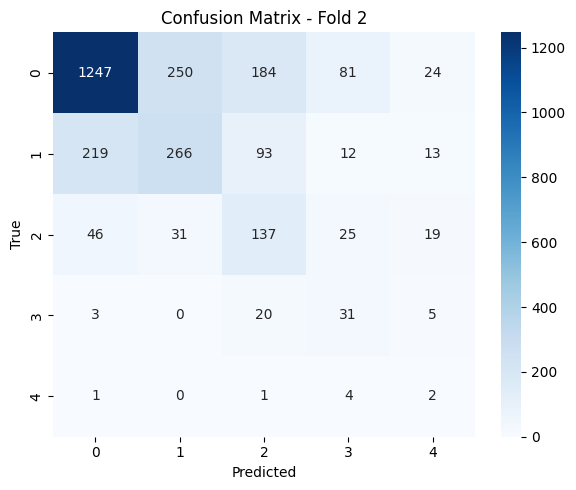

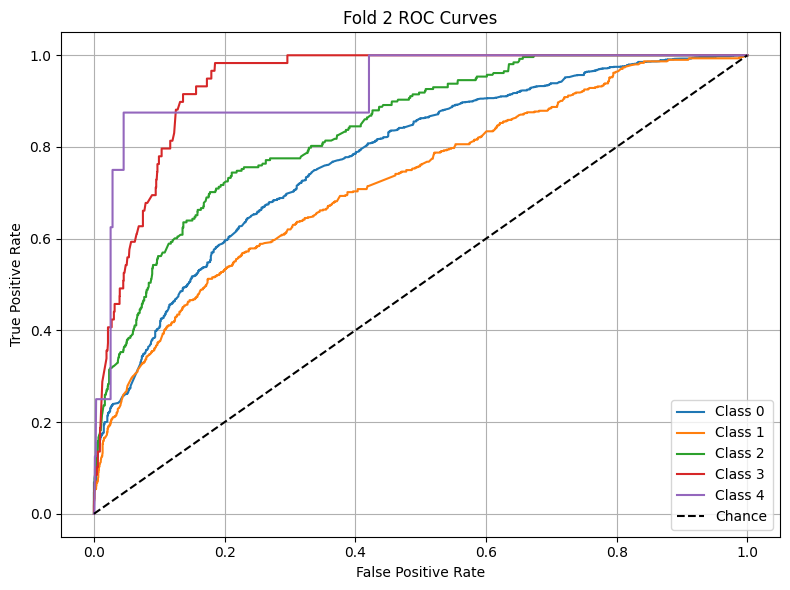


Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_accuracy = 0.62491


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


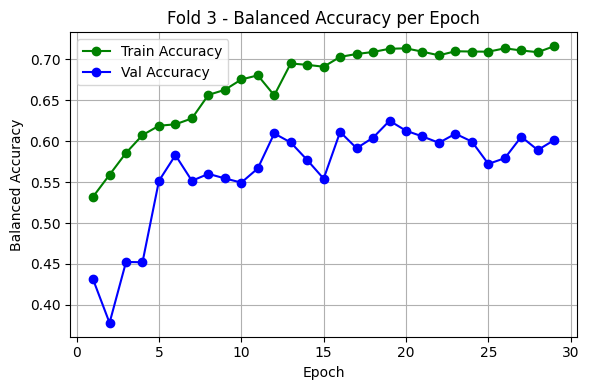


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77      1786
           1       0.46      0.43      0.45       603
           2       0.34      0.50      0.41       258
           3       0.18      0.53      0.27        59
           4       0.06      0.75      0.11         8

    accuracy                           0.62      2714
   macro avg       0.38      0.58      0.40      2714
weighted avg       0.69      0.62      0.65      2714



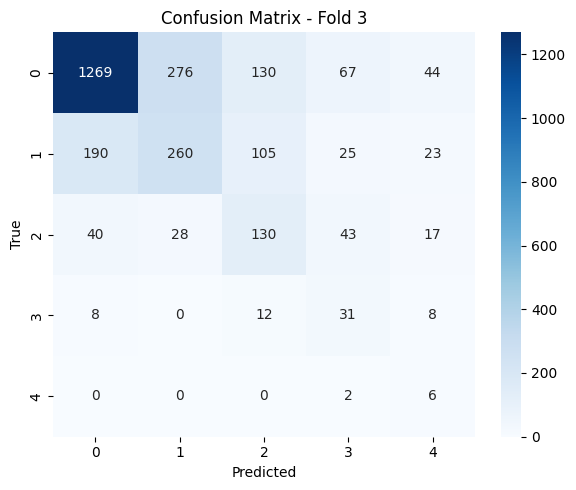

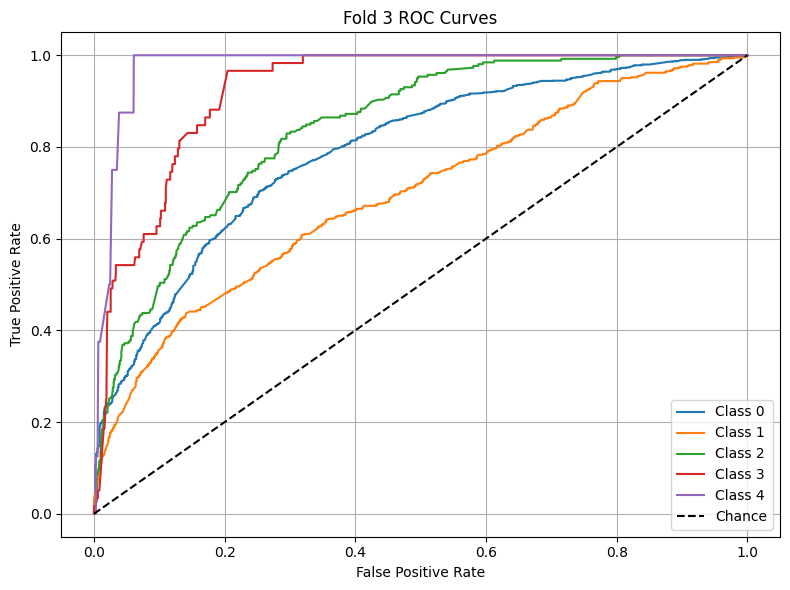


Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_accuracy = 0.61754


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


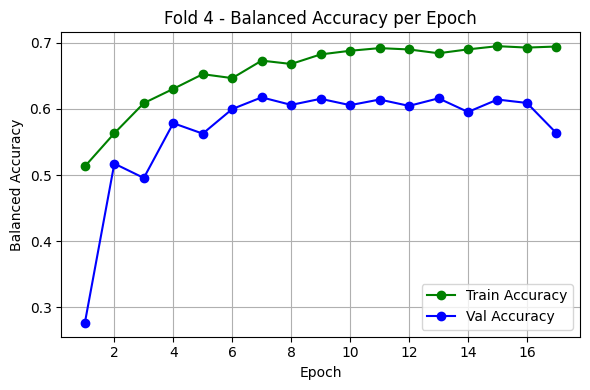


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77      1785
           1       0.48      0.38      0.42       603
           2       0.40      0.36      0.38       258
           3       0.12      0.61      0.20        59
           4       0.07      0.44      0.11         9

    accuracy                           0.62      2714
   macro avg       0.37      0.51      0.38      2714
weighted avg       0.67      0.62      0.64      2714



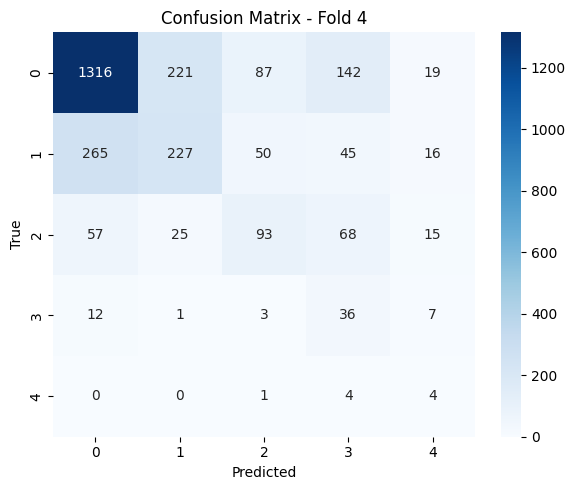

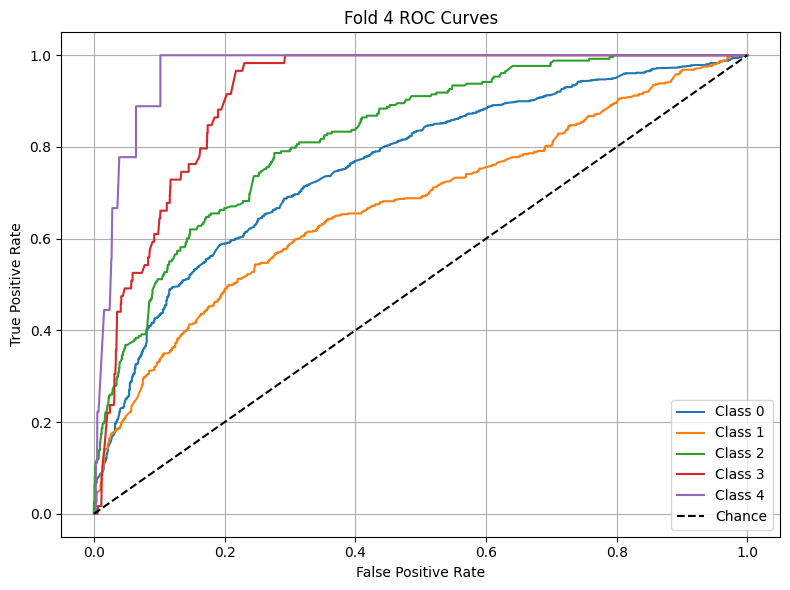


Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_accuracy = 0.64554


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


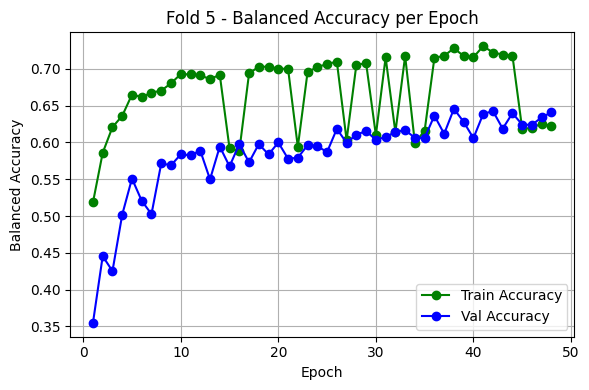


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.74      0.78      1785
           1       0.51      0.45      0.48       603
           2       0.35      0.51      0.41       258
           3       0.15      0.47      0.22        59
           4       0.10      0.44      0.16         9

    accuracy                           0.65      2714
   macro avg       0.39      0.52      0.41      2714
weighted avg       0.70      0.65      0.67      2714



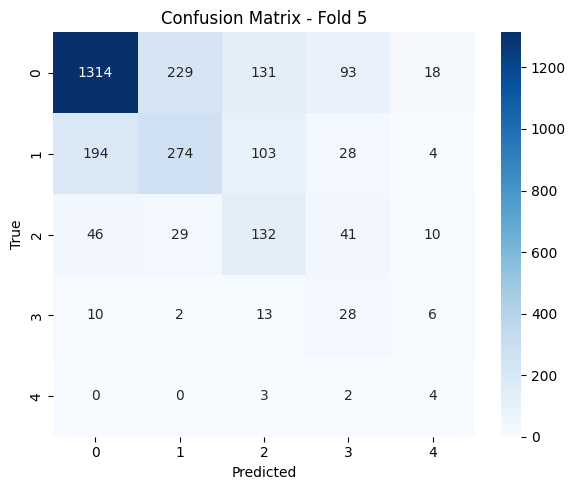

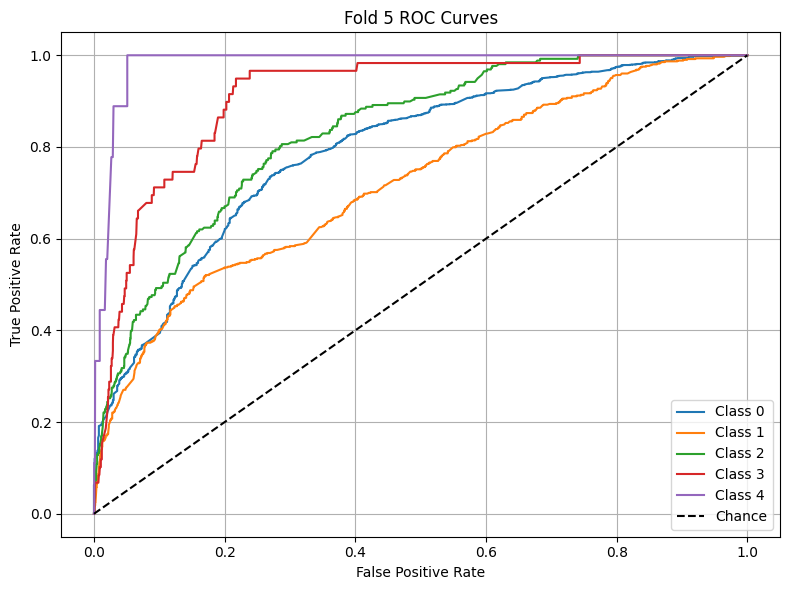


Average Accuracy: 0.6280
Average F1 Macro: 0.3955
Average AUC: 0.8403

Feature Importances:
video                     0.154263
exercise_context_sum_1    0.082949
exercise_count            0.076779
video_count               0.075185
user_month                0.066561
duration_days             0.064032
school                    0.057558
assignment                0.049481
chapter_count             0.046049
video_pause_count_1       0.039664
dtype: float64

=== Training Phase 2 ===

Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_accuracy = 0.60885


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


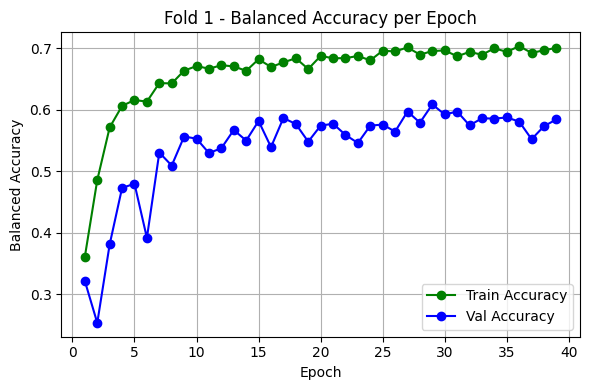


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77      1489
           1       0.43      0.38      0.41       488
           2       0.34      0.46      0.39       220
           3       0.15      0.52      0.24        54
           4       0.05      0.56      0.09         9

    accuracy                           0.61      2260
   macro avg       0.36      0.52      0.38      2260
weighted avg       0.69      0.61      0.64      2260



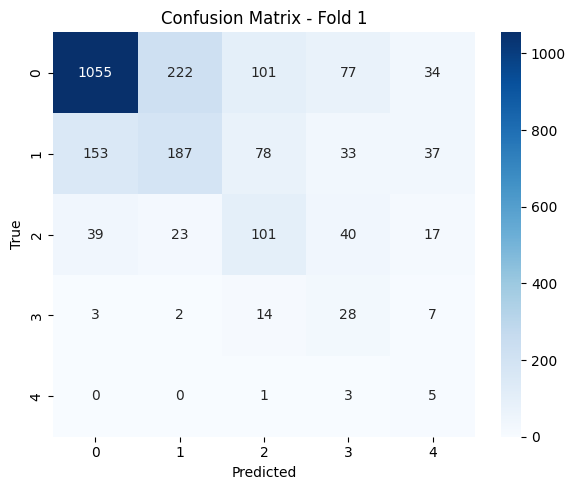

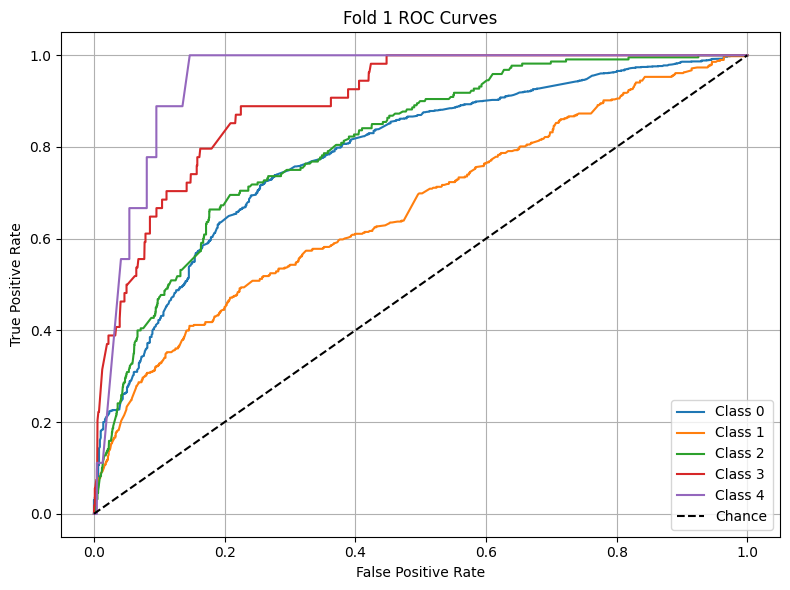


Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_accuracy = 0.59469


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


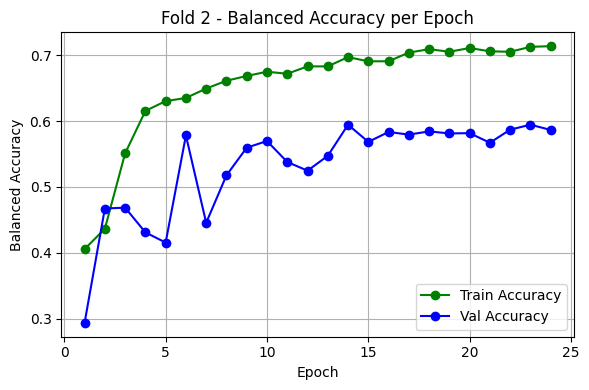


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.67      0.74      1489
           1       0.42      0.43      0.42       489
           2       0.32      0.45      0.37       219
           3       0.20      0.58      0.30        55
           4       0.08      0.62      0.15         8

    accuracy                           0.59      2260
   macro avg       0.37      0.55      0.40      2260
weighted avg       0.66      0.59      0.62      2260



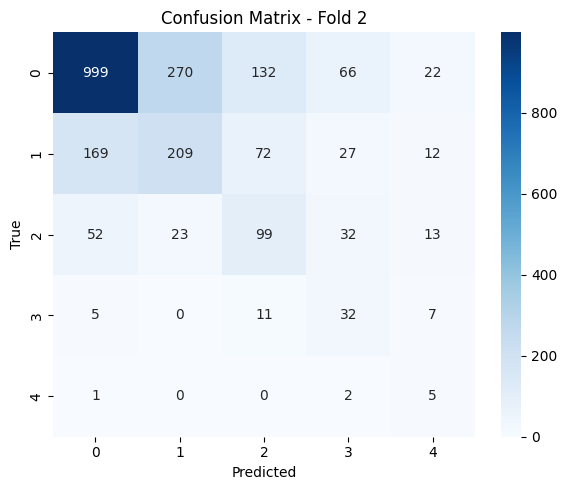

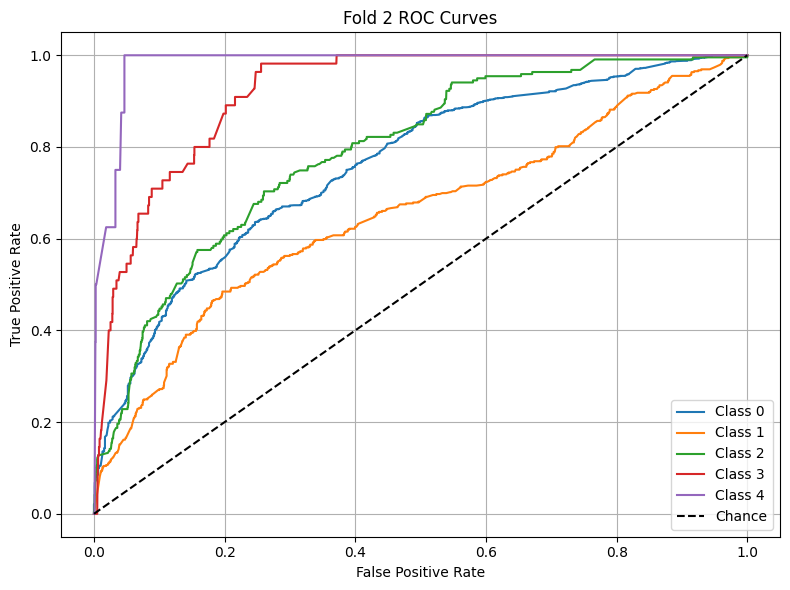


Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_accuracy = 0.61045


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


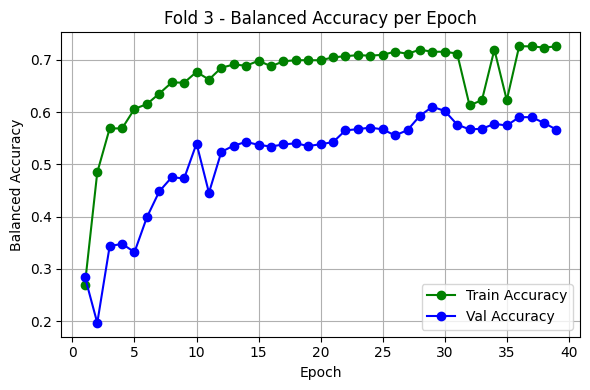


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.76      1489
           1       0.43      0.38      0.41       489
           2       0.32      0.53      0.40       219
           3       0.18      0.48      0.26        54
           4       0.07      0.62      0.12         8

    accuracy                           0.61      2259
   macro avg       0.37      0.54      0.39      2259
weighted avg       0.68      0.61      0.64      2259



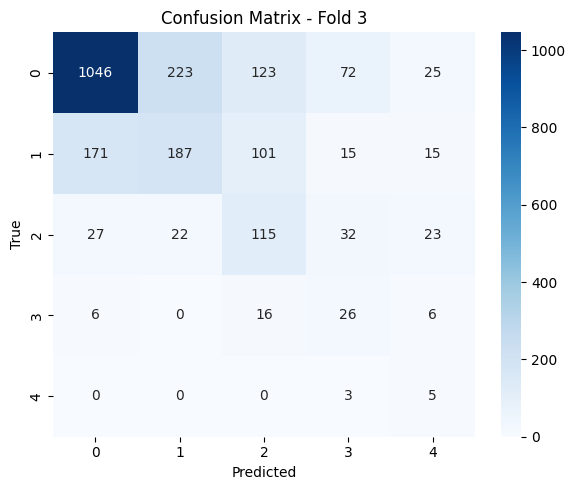

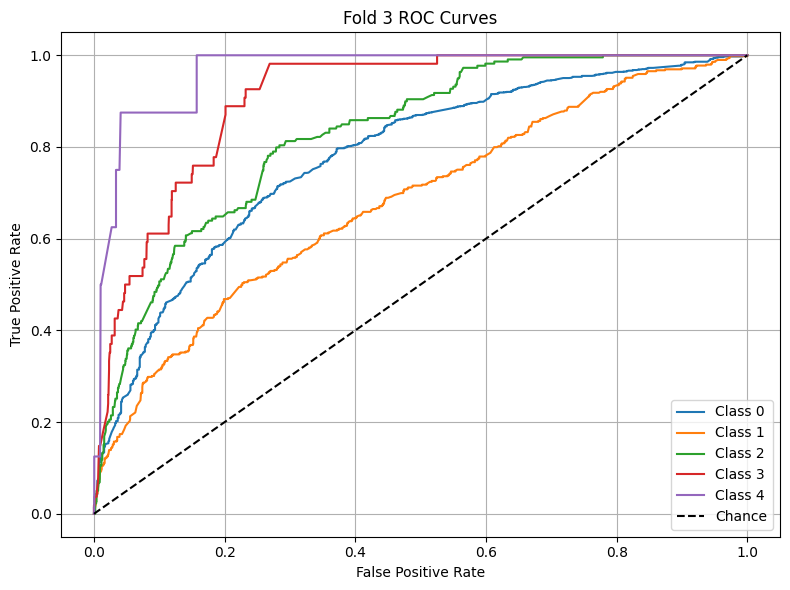


Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_accuracy = 0.61355


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


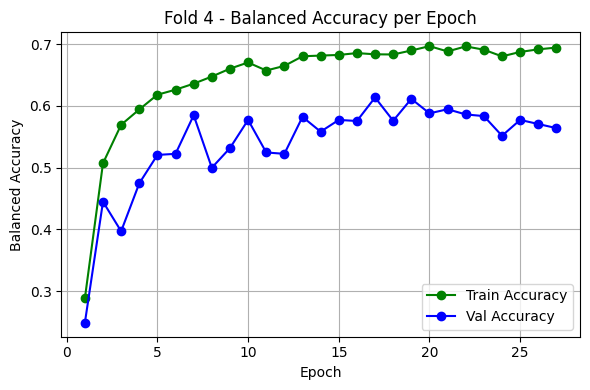


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.76      1489
           1       0.47      0.37      0.42       489
           2       0.34      0.50      0.41       219
           3       0.19      0.74      0.31        54
           4       0.09      0.62      0.16         8

    accuracy                           0.61      2259
   macro avg       0.38      0.59      0.41      2259
weighted avg       0.68      0.61      0.63      2259



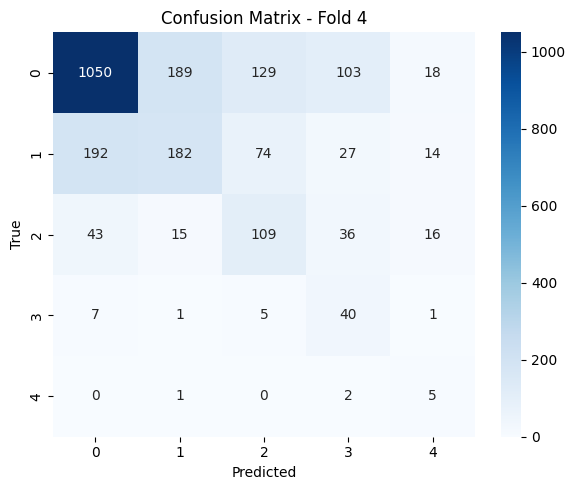

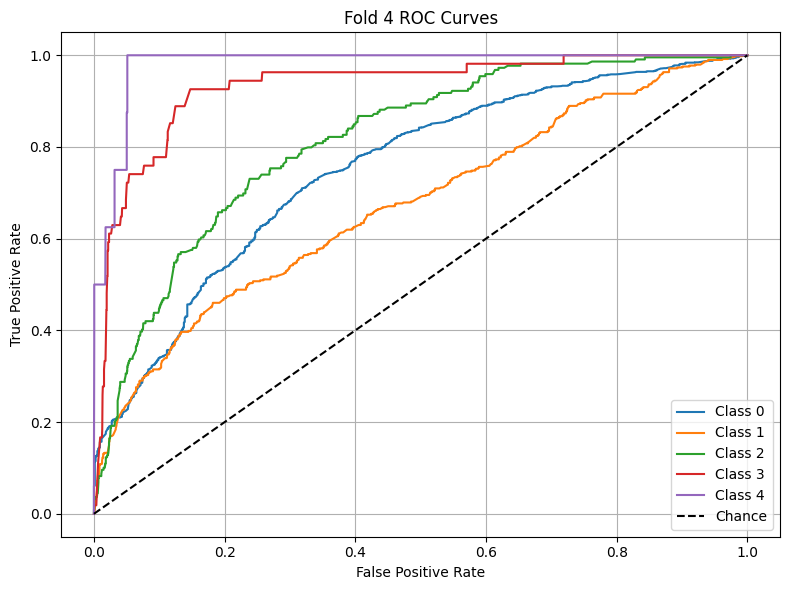


Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_accuracy = 0.60381


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


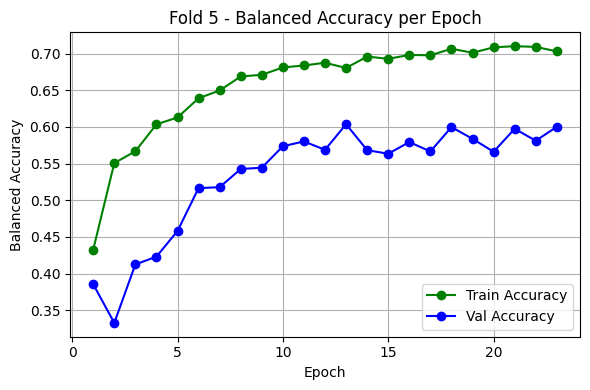


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.72      0.76      1490
           1       0.43      0.34      0.38       488
           2       0.33      0.43      0.37       219
           3       0.13      0.43      0.19        54
           4       0.09      0.75      0.15         8

    accuracy                           0.60      2259
   macro avg       0.35      0.53      0.37      2259
weighted avg       0.66      0.60      0.63      2259



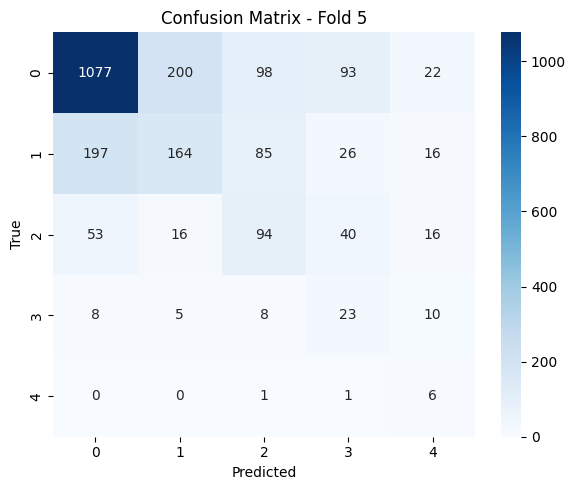

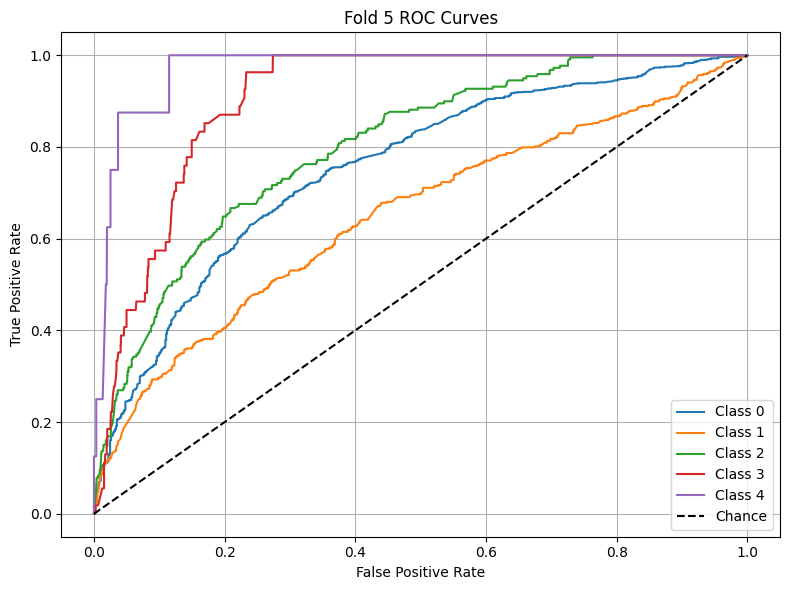


Average Accuracy: 0.6063
Average F1 Macro: 0.3891
Average AUC: 0.8239

Feature Importances:
assignment                         0.307286
video_count                        0.180042
remaining_time                     0.068827
duration_days                      0.061556
exercise_count                     0.038864
exam                               0.033482
video_time_between_views_std_2     0.031590
video_time_between_views_std_1     0.028052
exercise_perc_real_score_mean_2    0.025631
video                              0.025023
dtype: float64

=== Training Phase 3 ===

Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_accuracy = 0.61572


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


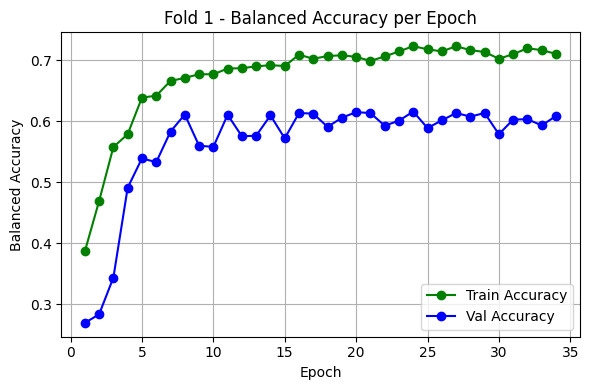


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77      1361
           1       0.47      0.40      0.43       459
           2       0.33      0.52      0.41       198
           3       0.13      0.47      0.20        49
           4       0.08      0.57      0.13         7

    accuracy                           0.62      2074
   macro avg       0.37      0.53      0.39      2074
weighted avg       0.69      0.62      0.64      2074



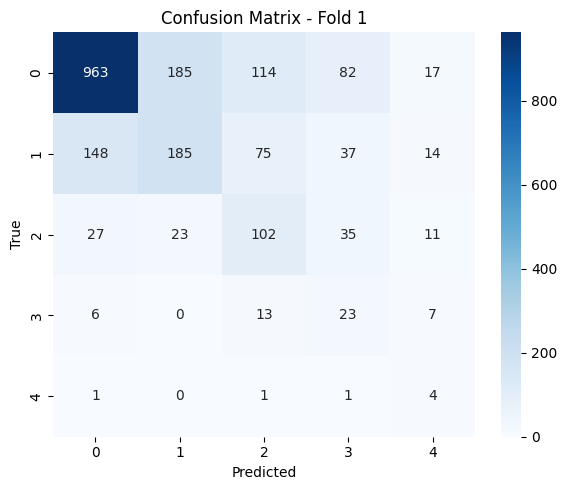

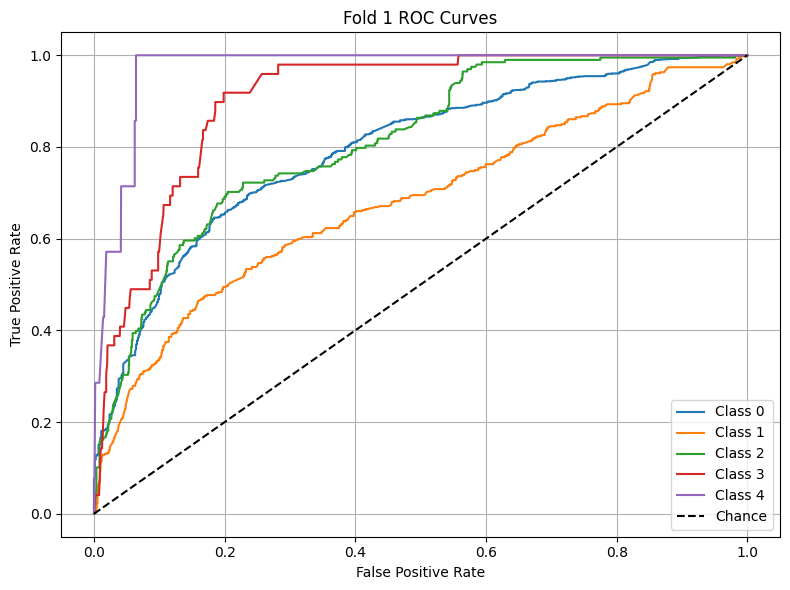


Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_accuracy = 0.58245


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


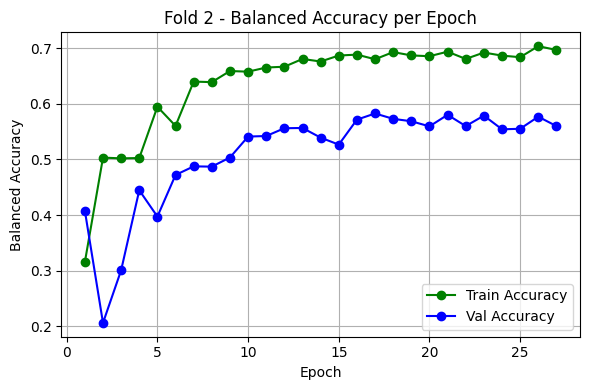


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.67      0.73      1360
           1       0.44      0.40      0.42       459
           2       0.34      0.38      0.36       198
           3       0.15      0.76      0.24        50
           4       0.04      0.29      0.07         7

    accuracy                           0.58      2074
   macro avg       0.36      0.50      0.36      2074
weighted avg       0.67      0.58      0.61      2074



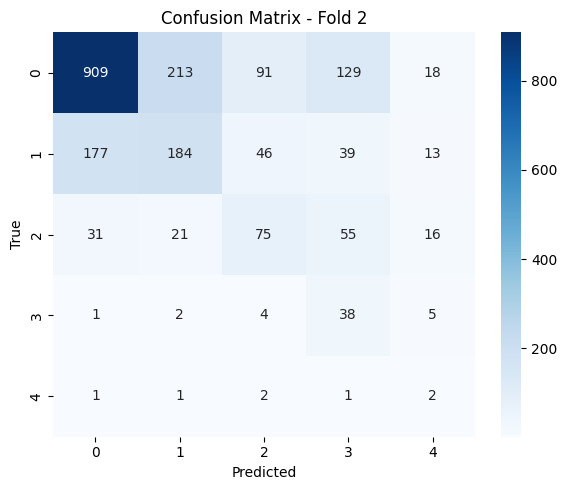

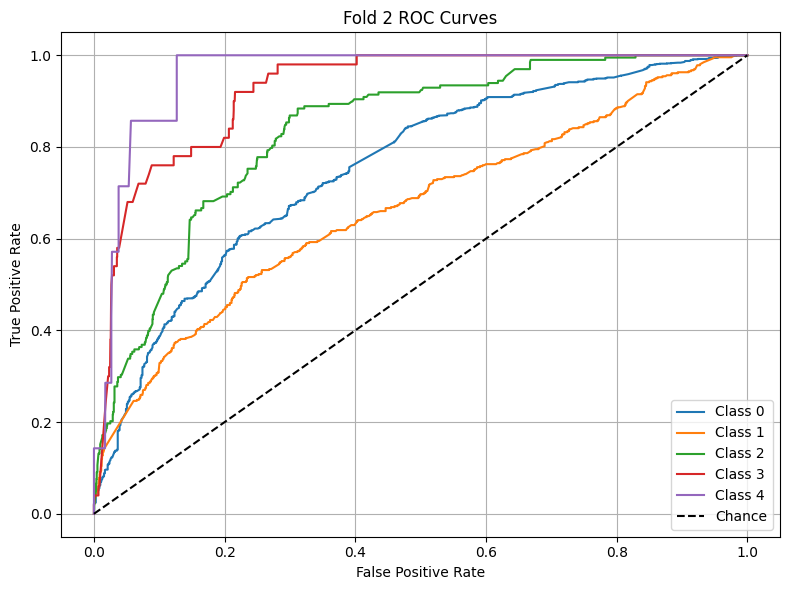


Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_accuracy = 0.64224


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


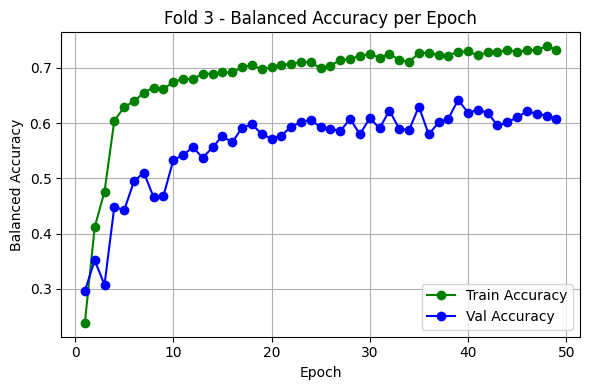


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79      1360
           1       0.51      0.37      0.43       459
           2       0.33      0.48      0.39       198
           3       0.18      0.48      0.26        50
           4       0.08      0.57      0.14         7

    accuracy                           0.64      2074
   macro avg       0.38      0.53      0.40      2074
weighted avg       0.69      0.64      0.66      2074



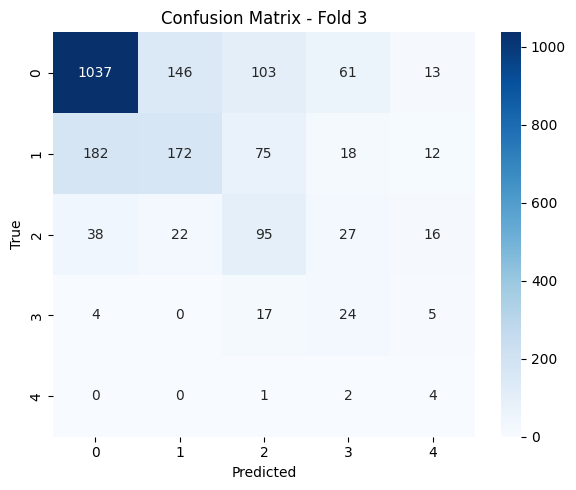

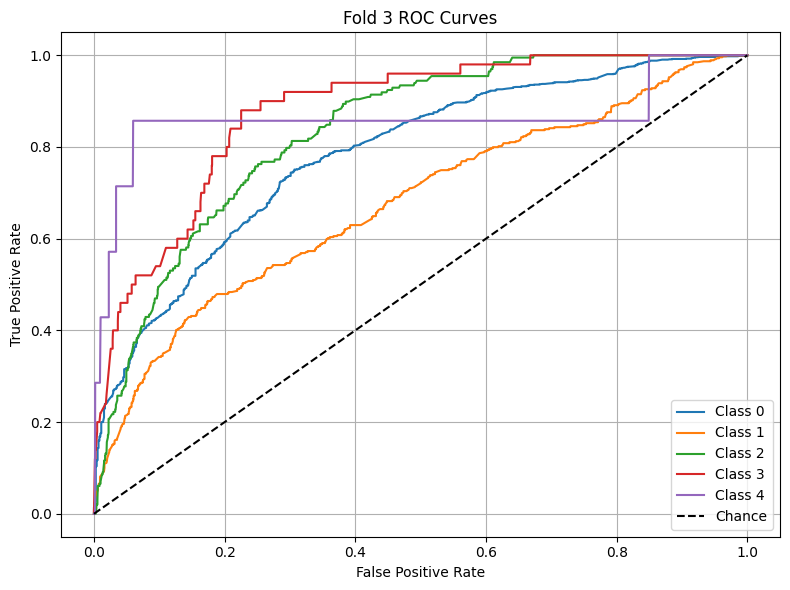


Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_accuracy = 0.62633


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


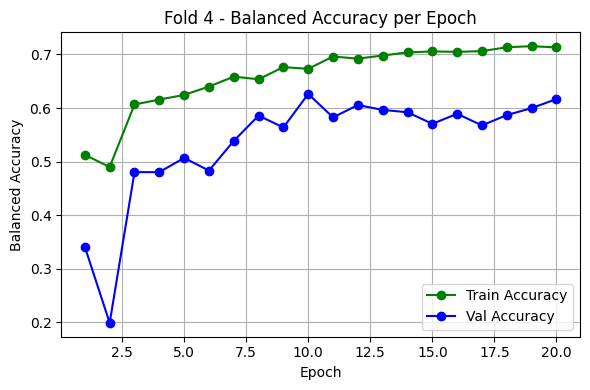


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77      1360
           1       0.48      0.39      0.43       459
           2       0.33      0.32      0.32       198
           3       0.19      0.48      0.27        50
           4       0.07      0.86      0.14         7

    accuracy                           0.63      2074
   macro avg       0.37      0.56      0.39      2074
weighted avg       0.66      0.63      0.64      2074



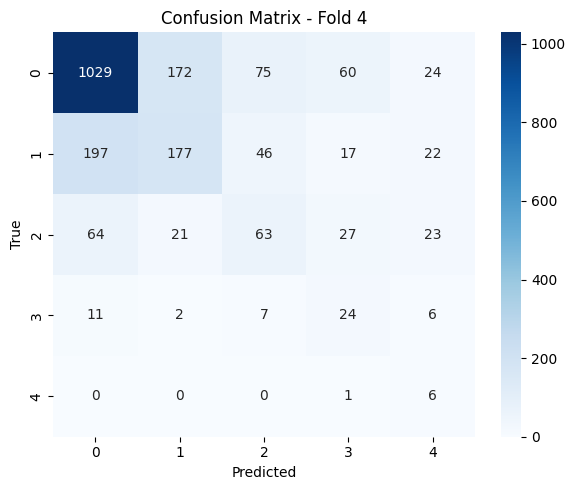

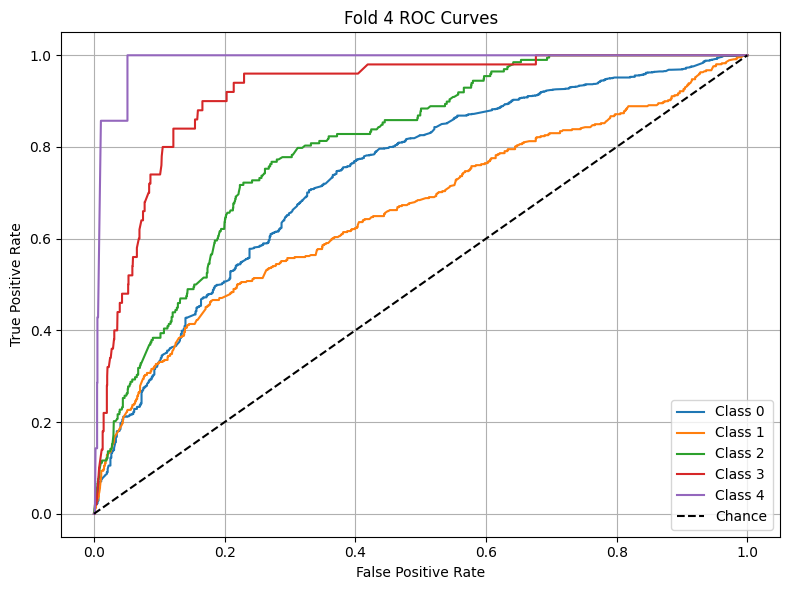


Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_accuracy = 0.60492


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


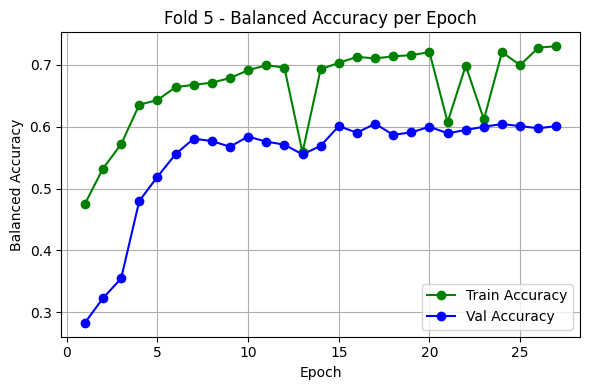


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.76      1360
           1       0.46      0.38      0.41       460
           2       0.30      0.47      0.37       197
           3       0.15      0.47      0.23        49
           4       0.04      0.29      0.07         7

    accuracy                           0.60      2073
   macro avg       0.35      0.46      0.37      2073
weighted avg       0.67      0.60      0.63      2073



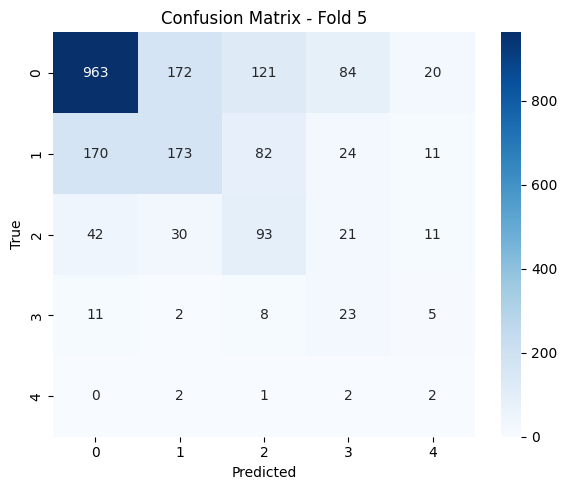

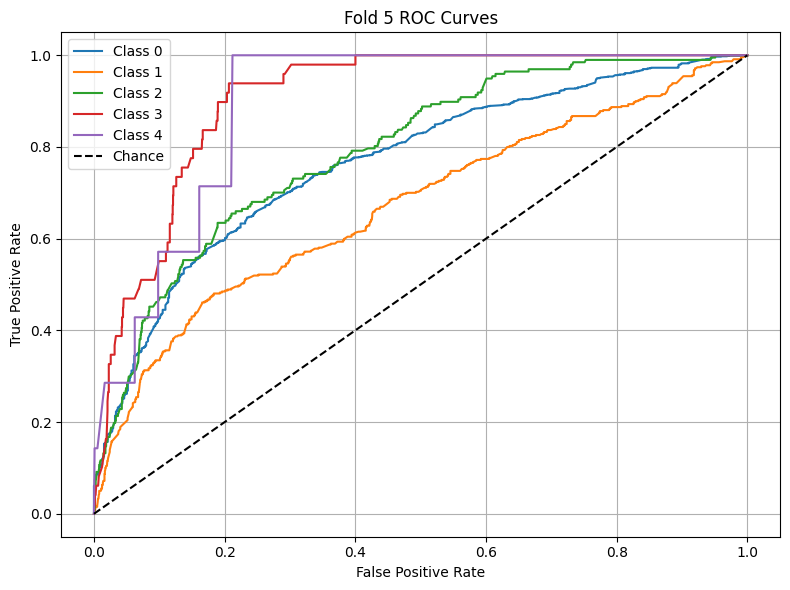


Average Accuracy: 0.6143
Average F1 Macro: 0.3818
Average AUC: 0.8185

Feature Importances:
assignment                       0.206307
certificate                      0.111972
video_speed_avg_3                0.065157
remaining_time                   0.063527
video_count                      0.059815
user_time_since_last_course      0.057453
school                           0.037892
exercise_diff_mean_3             0.036692
user_month                       0.034070
video_percentage_watch_time_2    0.034021
dtype: float64

=== Training Phase 4 ===

Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_accuracy = 0.66017


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


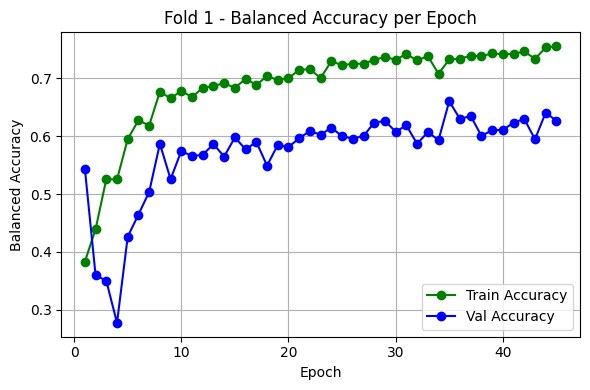


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80      1000
           1       0.53      0.41      0.46       355
           2       0.33      0.37      0.35       139
           3       0.24      0.59      0.34        39
           4       0.14      0.67      0.23         6

    accuracy                           0.66      1539
   macro avg       0.41      0.57      0.44      1539
weighted avg       0.68      0.66      0.67      1539



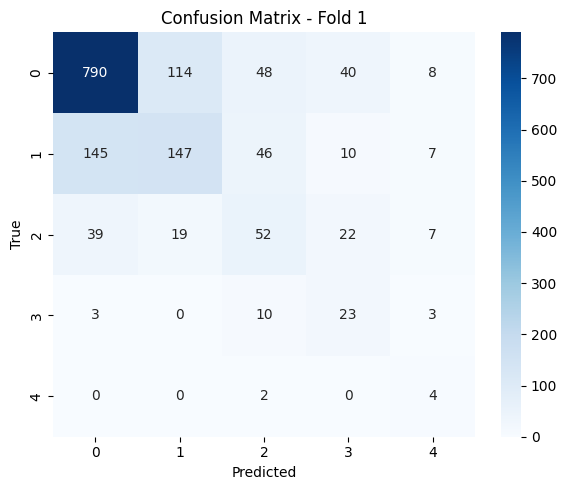

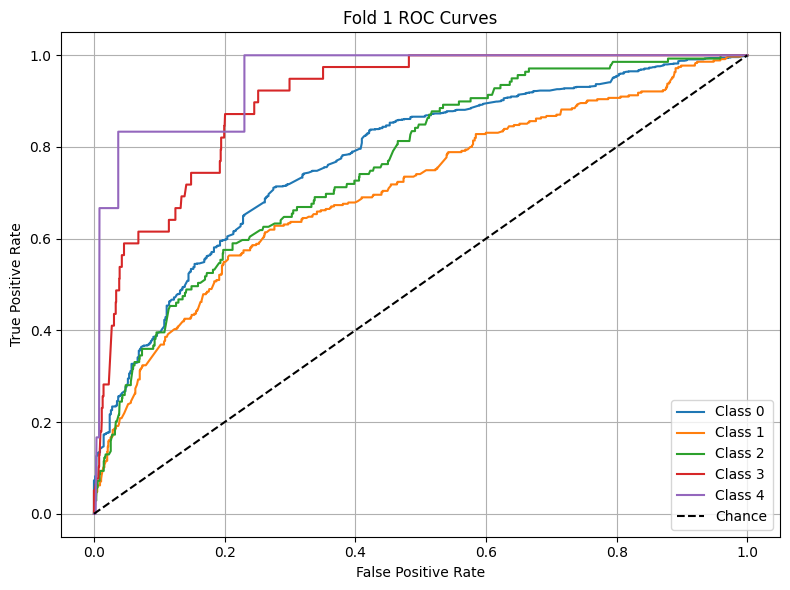


Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_accuracy = 0.64133


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


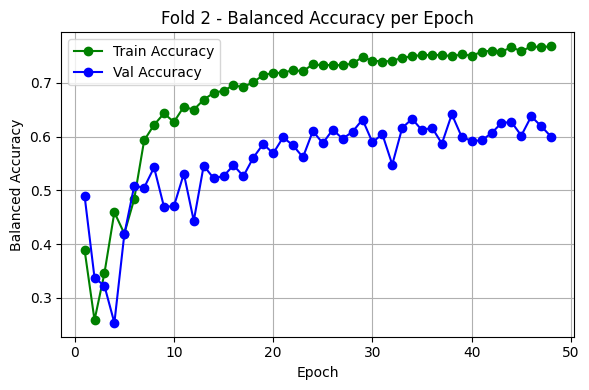


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.73      0.76      1000
           1       0.47      0.45      0.46       355
           2       0.50      0.53      0.52       139
           3       0.27      0.57      0.37        40
           4       0.03      0.40      0.06         5

    accuracy                           0.64      1539
   macro avg       0.41      0.54      0.43      1539
weighted avg       0.68      0.64      0.66      1539



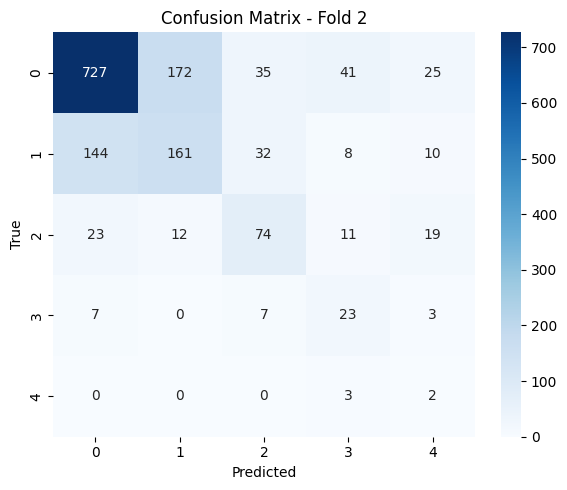

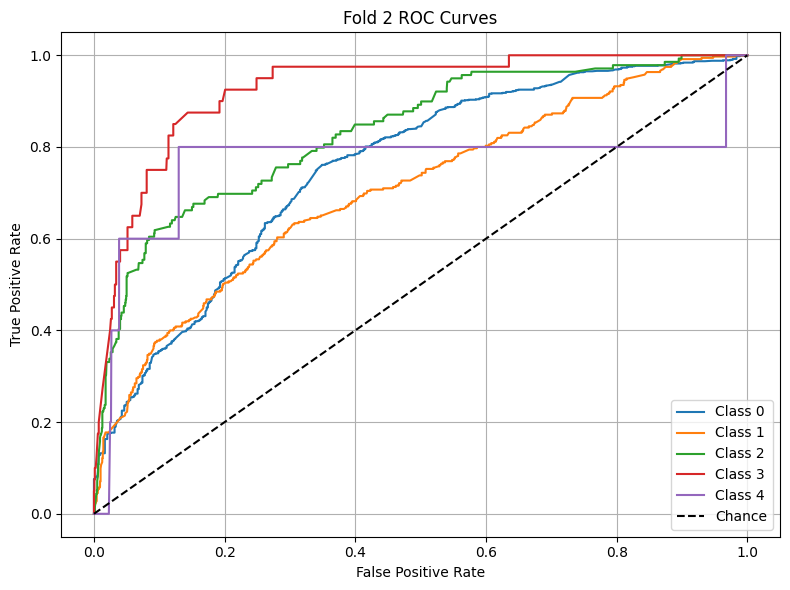


Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_accuracy = 0.63483


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


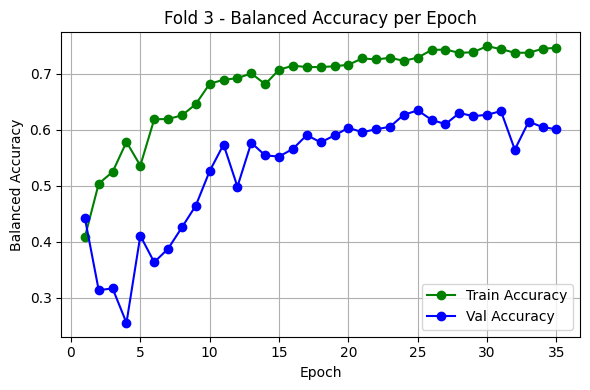


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.76       999
           1       0.47      0.48      0.47       355
           2       0.39      0.51      0.44       139
           3       0.25      0.53      0.34        40
           4       0.14      0.67      0.23         6

    accuracy                           0.63      1539
   macro avg       0.41      0.58      0.45      1539
weighted avg       0.67      0.63      0.65      1539



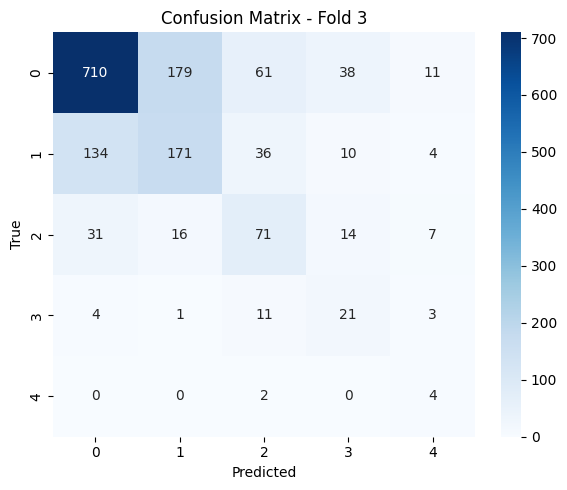

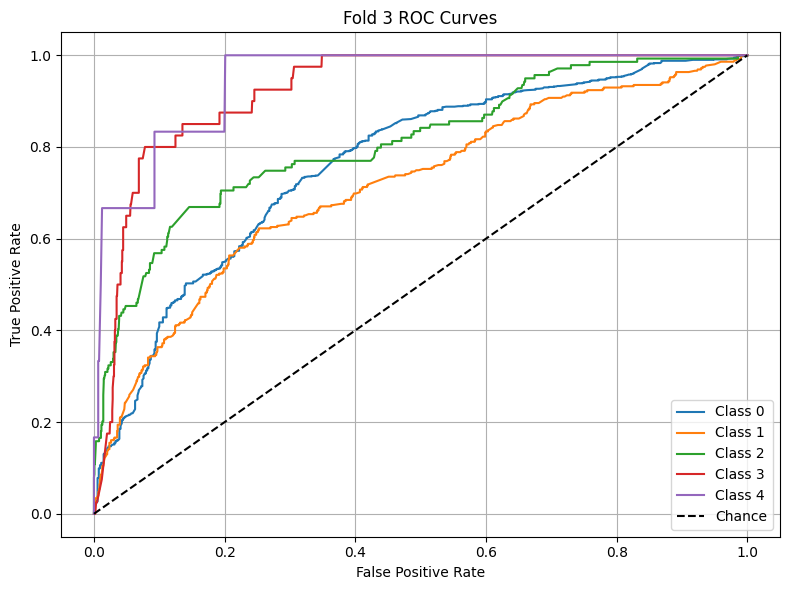


Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_accuracy = 0.65345


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


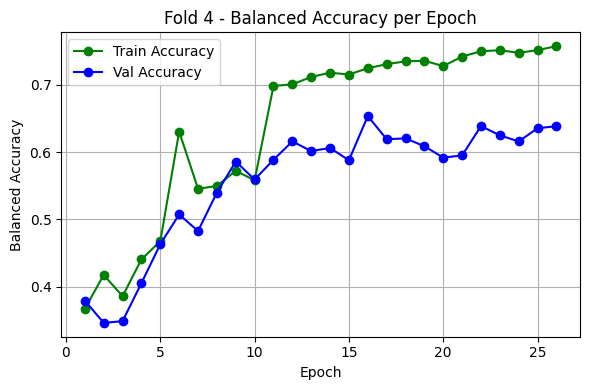


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.80      0.80       999
           1       0.52      0.32      0.40       356
           2       0.35      0.46      0.40       138
           3       0.26      0.54      0.35        39
           4       0.12      0.67      0.20         6

    accuracy                           0.65      1538
   macro avg       0.41      0.56      0.43      1538
weighted avg       0.67      0.65      0.65      1538



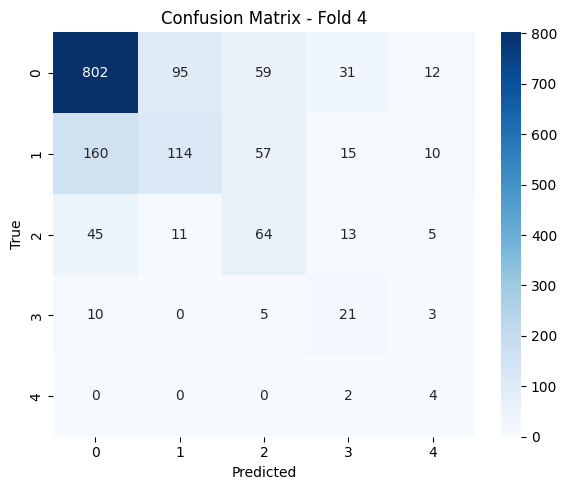

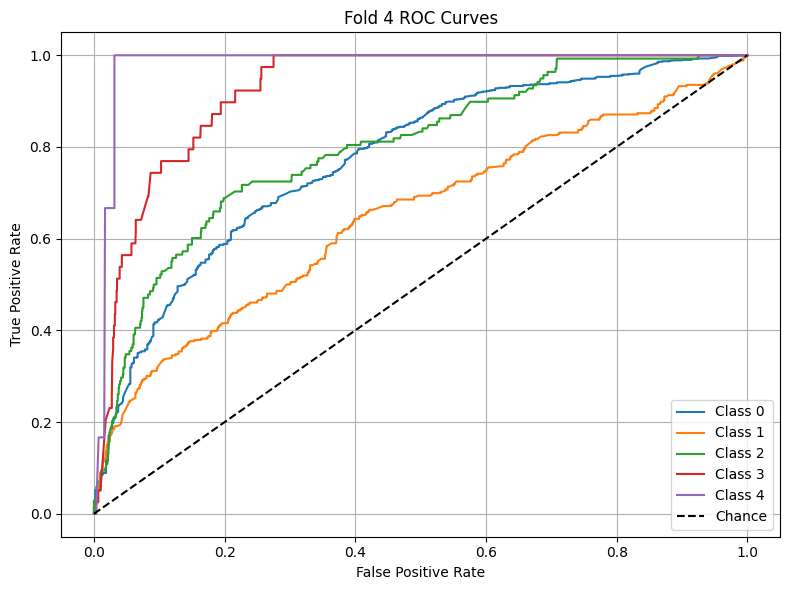


Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_accuracy = 0.62939


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


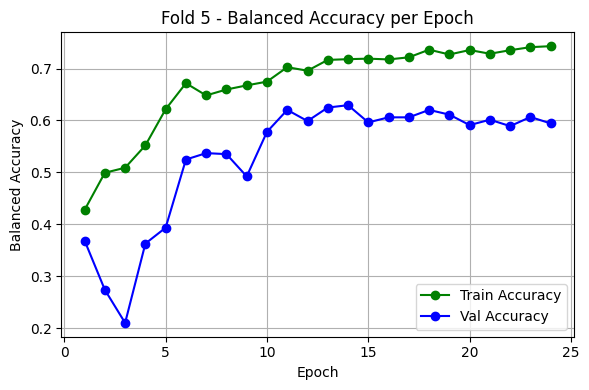


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77       999
           1       0.53      0.42      0.47       356
           2       0.25      0.40      0.31       138
           3       0.29      0.69      0.41        39
           4       0.03      0.17      0.05         6

    accuracy                           0.63      1538
   macro avg       0.38      0.48      0.40      1538
weighted avg       0.68      0.63      0.65      1538



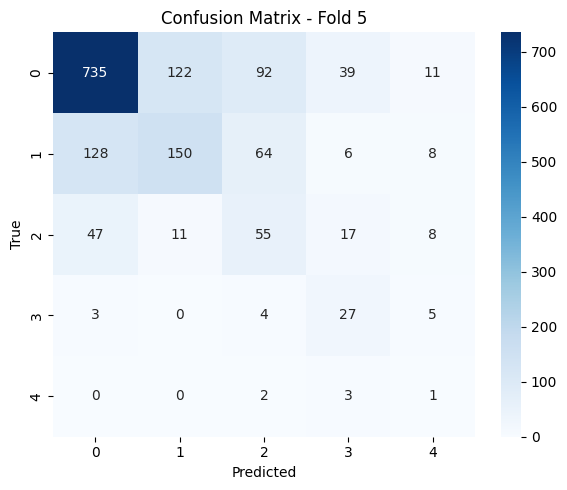

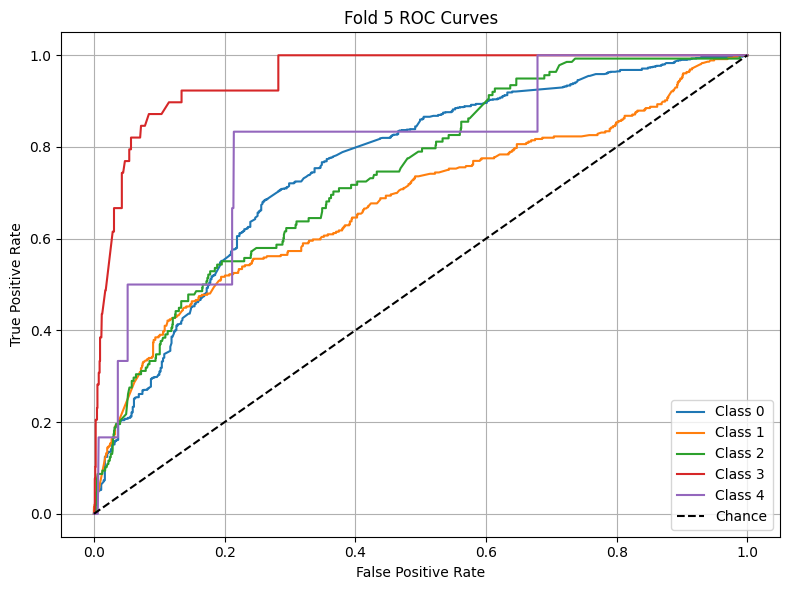


Average Accuracy: 0.6438
Average F1 Macro: 0.4297
Average AUC: 0.8119

Feature Importances:
assignment                       0.255996
video                            0.160747
exercise_correct_mean_2          0.061063
duration_days                    0.046331
exercise_correct_mean_4          0.045754
video_percentage_watch_time_4    0.043577
exercise_count                   0.030492
certificate                      0.028604
entropy_time_comment_phase2      0.026979
exercise_hour_entropy_1          0.026138
dtype: float64


In [10]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_not_balance_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics



Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.59      0.71       568
           1       0.16      0.38      0.23        63
           2       0.11      0.33      0.17        43
           3       0.05      0.13      0.07        15
           4       0.00      0.00      0.00         9

    accuracy                           0.54       698
   macro avg       0.24      0.29      0.23       698
weighted avg       0.74      0.54      0.61       698



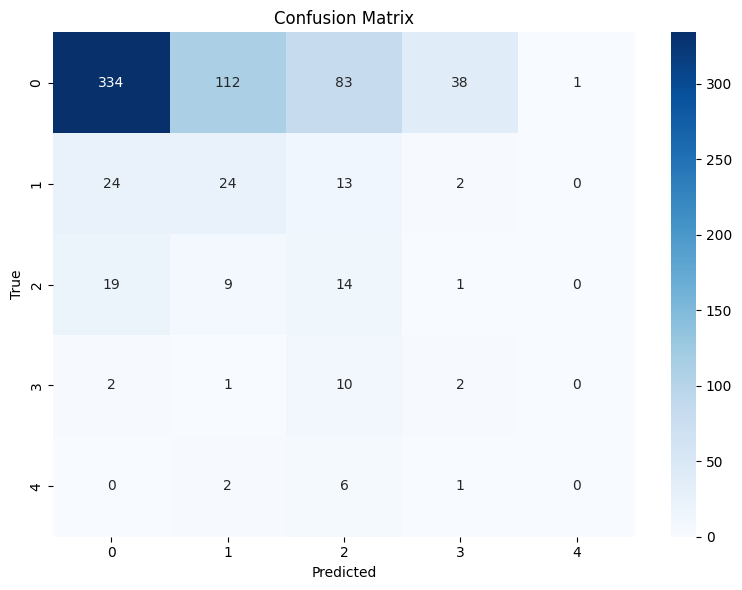


Test AUC (macro-average, OVR): 0.7275


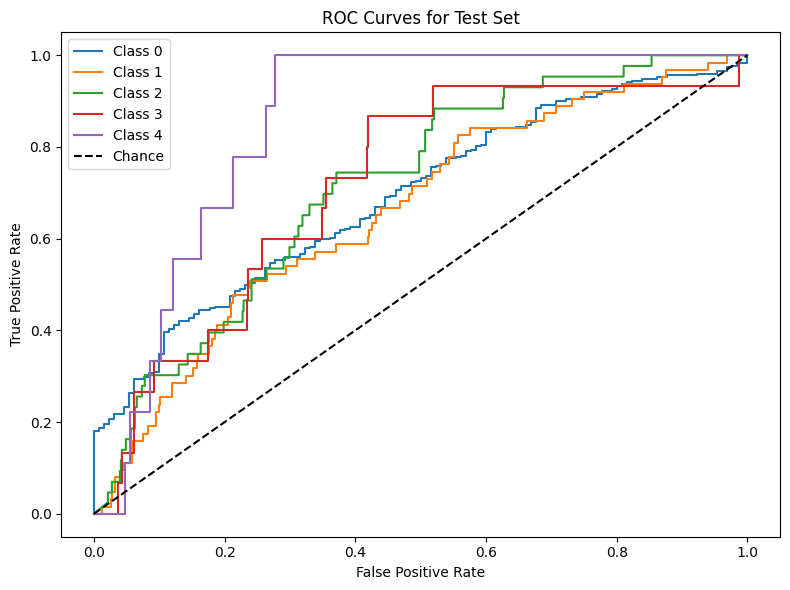


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.56      0.68       544
           1       0.10      0.24      0.15        59
           2       0.12      0.38      0.18        42
           3       0.03      0.07      0.04        14
           4       0.09      0.11      0.10         9

    accuracy                           0.50       668
   macro avg       0.24      0.27      0.23       668
weighted avg       0.72      0.50      0.58       668



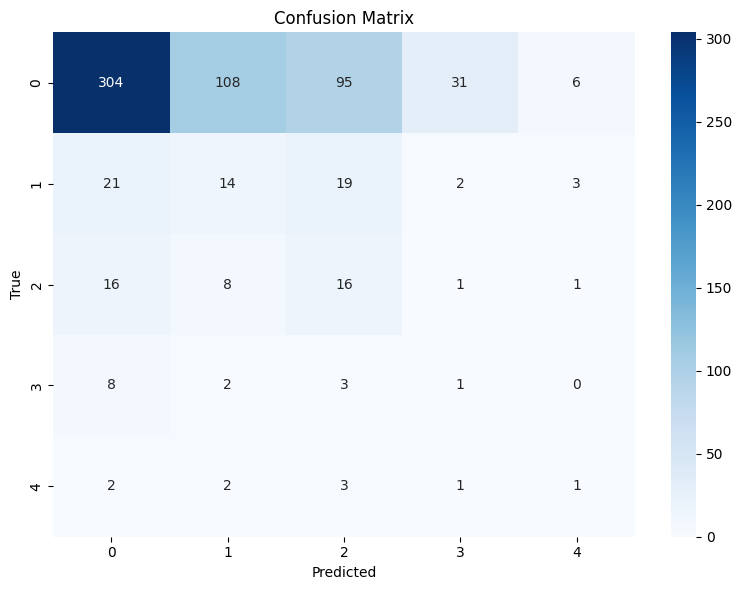


Test AUC (macro-average, OVR): 0.6466


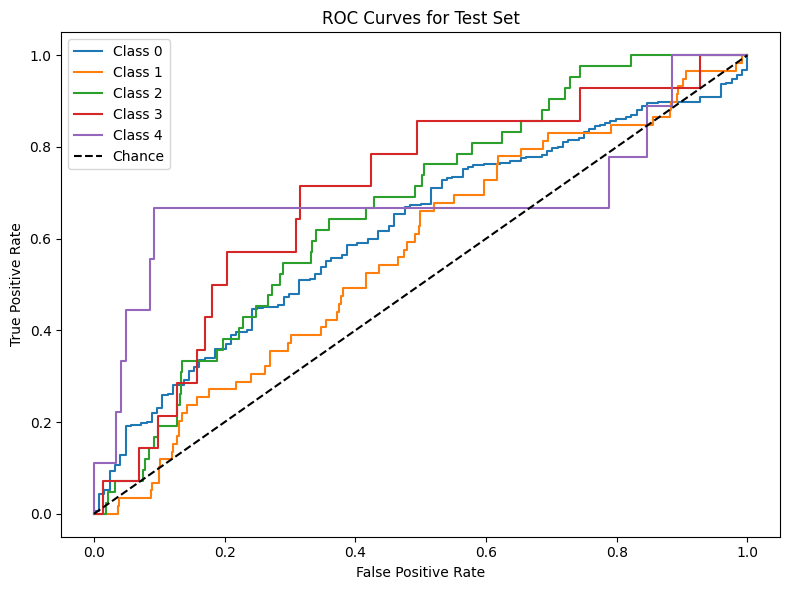


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.67      0.76       455
           1       0.14      0.29      0.19        52
           2       0.09      0.24      0.13        29
           3       0.06      0.10      0.08        10
           4       0.22      0.25      0.24         8

    accuracy                           0.60       554
   macro avg       0.28      0.31      0.28       554
weighted avg       0.75      0.60      0.66       554



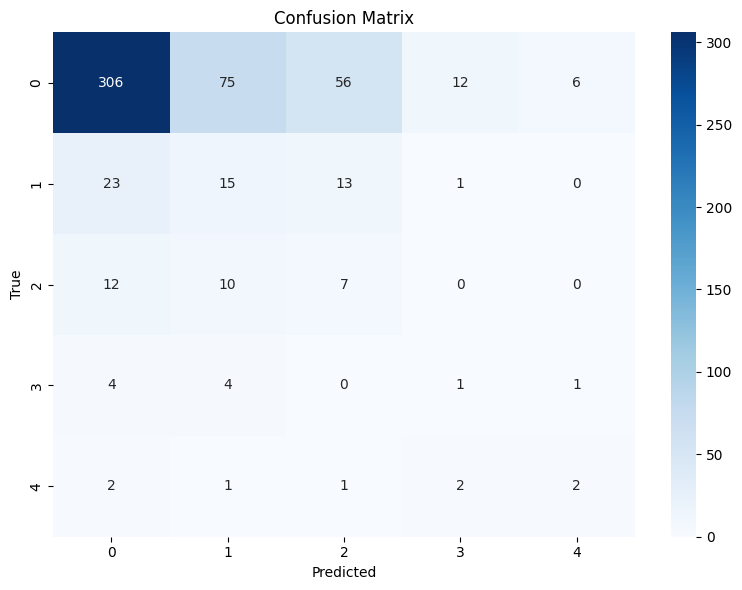


Test AUC (macro-average, OVR): 0.6444


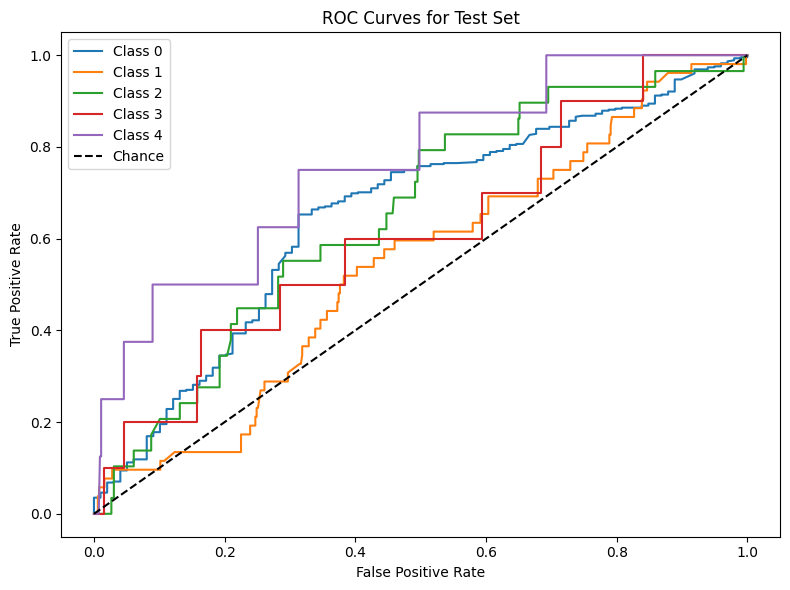


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.58      0.70       395
           1       0.12      0.30      0.17        40
           2       0.09      0.33      0.14        24
           3       0.12      0.10      0.11        10
           4       0.00      0.00      0.00         8

    accuracy                           0.53       477
   macro avg       0.24      0.26      0.22       477
weighted avg       0.73      0.53      0.60       477



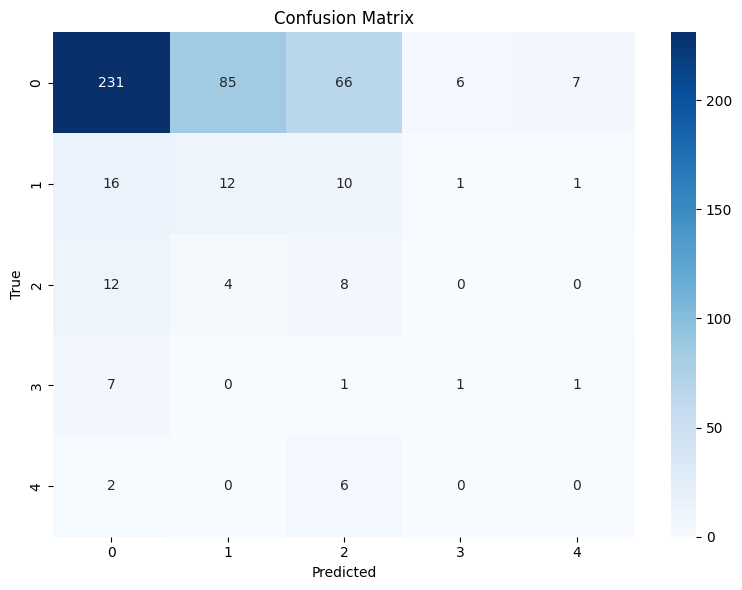


Test AUC (macro-average, OVR): 0.6832


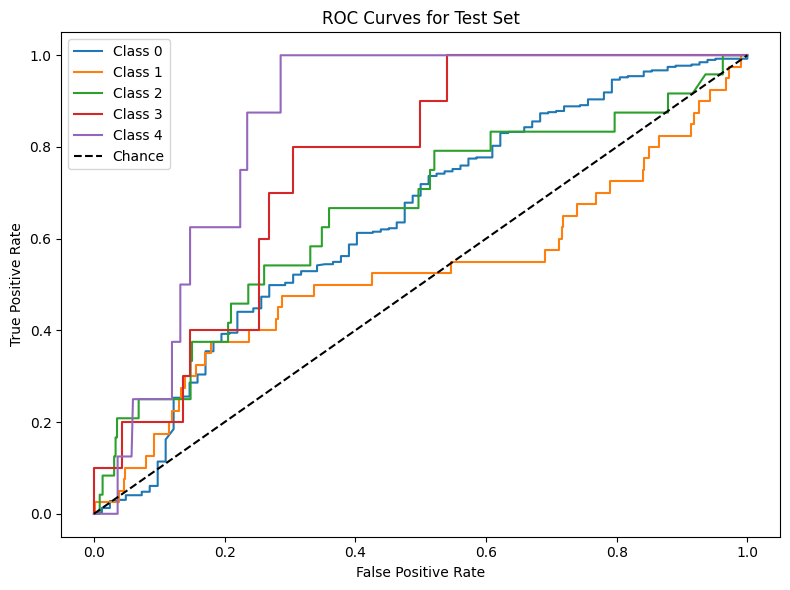

In [11]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)